# Sonic Log Reconstruction notebook

Main goals:
- Improve reconstruction
    - [x] Linear regression is at 89% with 140-150 in RMSE
    - [x] Try other regerssors
        - [x] RF, GB, KNN, SVR
- [x] Look at feaure importance?
- Regressions between transformed spaces (EMD, EWT, ???)
    - Decompose inputs and regress from decomposition-space to output
        - X -> T(X) -> Y
    - Decompose output and regress from inputs to decomposed output, then recombine
        - X -> T(Y) -> Y
    - Decompose at both ends?
        - X -> T(X) -> T(Y) -> Y
- Different regimes of missing data
    - [x] Sandstone section missing
    - [x] Last section missing
    - [x] \>50% missing
    - [x] \>75% missing

Side goals:
- Check performance on other wells
    - Get info about contiguous logging sections in each well
    - Cross-relate these to fiind overlapping contiguous blocks
    - If start points and section lenghts are the same, the overlap completely
    - Need algo for determining when one section is contained in another (likely fixable with pandas, series and indexes)
- Check performance for other available logs
    - Generate all combinations of log-availability
    - For each combination, form the dataset with this availability and run the regression

What has been done:
- Linear regression of data with MAR split
- RF/GB/KNN/SVM regression of data with MAR split
- RF regressor with MNAR split data
    - Cases: sandstone missing, last section missing, 50% in chunks, 75% in chunks, large missing middle section
- Investigated optimality of feature combinations


To do:
- Check performance on other wells
- Regress using EMD as input
- Regress using EWT as input
- Regress using EMD as output
- Regress using EWT as output

Ideas:
- Spline interpolate trendlines to get a baseline for comparing sections with missing middle
- Does taking the log before regression do anything to the performance?
- Does scaling the data before regression do much at all?




## Results and notes

**When using train/test split with MAR data:**

- Linear regression:        RMSE ~ 145, R2 = 0.898
- Random Forest:            RMSE ~  17, R2 = 0.988
- Gradient Boosting:        RMSE ~  35, R2 = 0.976
- KNN regressor:            RMSE ~  41, R2 = 0.976
- Support Vector Regressor: RMSE ~ 134, R2 = 0.972

**When having missing sections, MNAR:**

- Linear regression:        RMSE ~ 1100, R2 = -19.0
- Random Forest:            RMSE ~   45, R2 = 0.185
- Gradient Boosting:        RMSE ~  112, R2 = -1.00
- KNN regressor:            RMSE ~  110, R2 = -0.97
- Support Vector Regressor: RMSE ~ 1476, R2 = -25.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import seaborn as sns


from scipy.linalg import svd
from sklearn.metrics import mean_squared_error
from PyEMD import EMD  # pipenv install EMD-signal
from ewtpy import EWT1D  # pipenv install ewtpy
from statsmodels.tsa.stattools import acf
from torch.utils.data import DataLoader, TensorDataset
from fbm import FBM  # pip install fbm
from sklearn.decomposition import PCA

In [4]:
X = pd.read_csv("x.csv", delimiter=",")
Y = pd.read_csv("y.csv", delimiter=",", dtype=np.float64)

print(f"Data read as: X -- {X.shape}, Y -- {Y.shape}")

Data read as: X -- (28524, 8), Y -- (28524, 1)


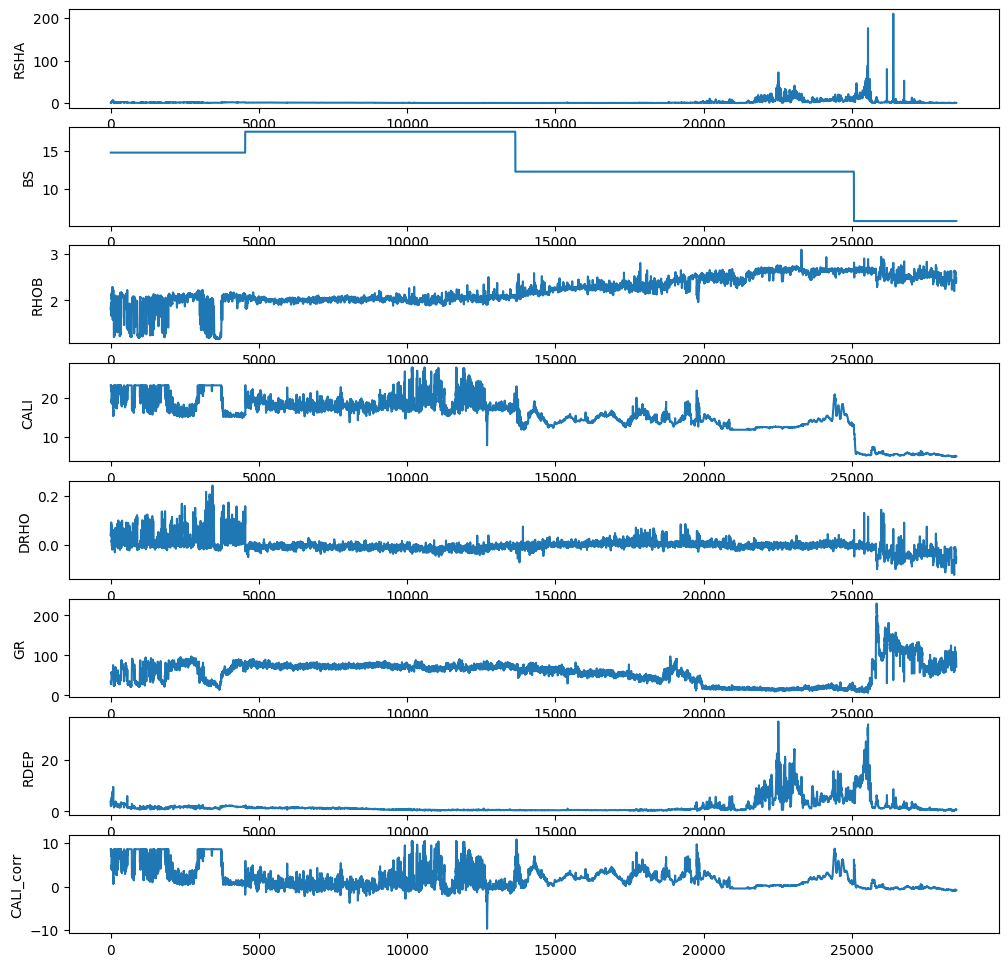

In [5]:
plt.figure(figsize=(12,12))
for i, c in enumerate(X.columns):
    plt.subplot(len(X.columns), 1, i+1)
    plt.plot(X[c])
    plt.ylabel(c)

plt.show()

In [6]:
for c in X.columns:
    print(f"Series {c} has {sum(X[c].isna())} NaN-values")

Series RSHA has 0 NaN-values
Series BS has 0 NaN-values
Series RHOB has 0 NaN-values
Series CALI has 0 NaN-values
Series DRHO has 0 NaN-values
Series GR has 0 NaN-values
Series RDEP has 0 NaN-values
Series CALI_corr has 0 NaN-values


## PCA

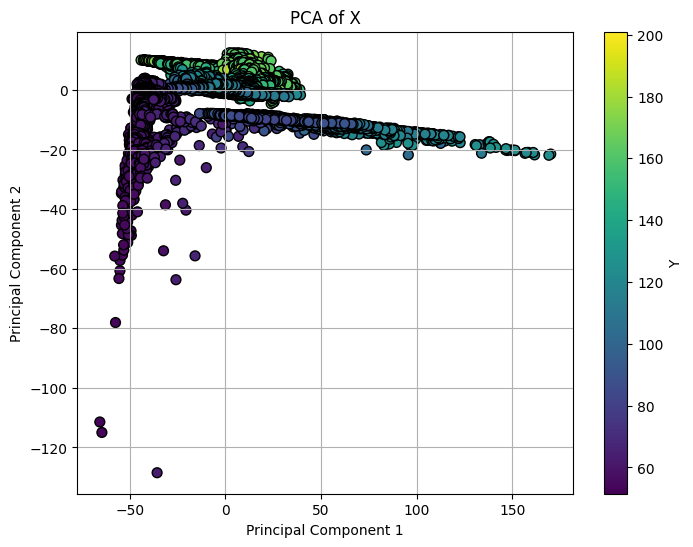

In [7]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y.to_numpy(), cmap='viridis', edgecolor='k', s=50)
plt.title('PCA of X')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Y')
plt.grid(True)
plt.show()

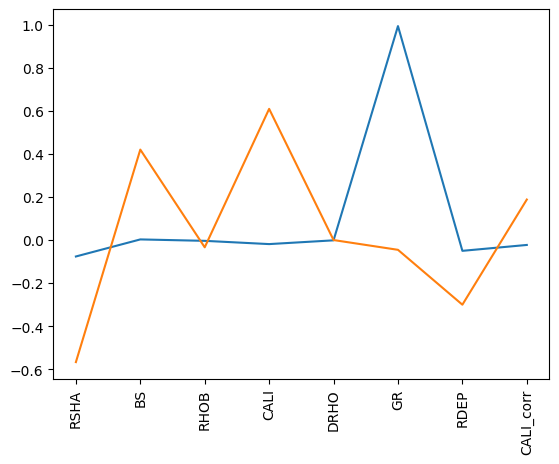

In [267]:
plt.plot(pca.components_[0])
plt.plot(pca.components_[1])
plt.xticks(range(len(X.columns)), X.columns, rotation=90)
plt.show()

Mean Squared Error: 143.4620167778298
R^2 Score: 0.8995457829942496


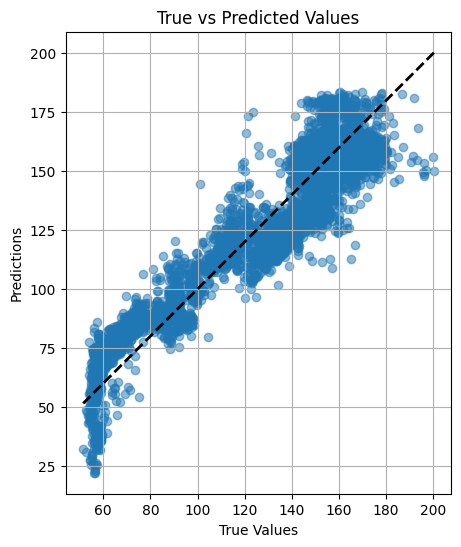

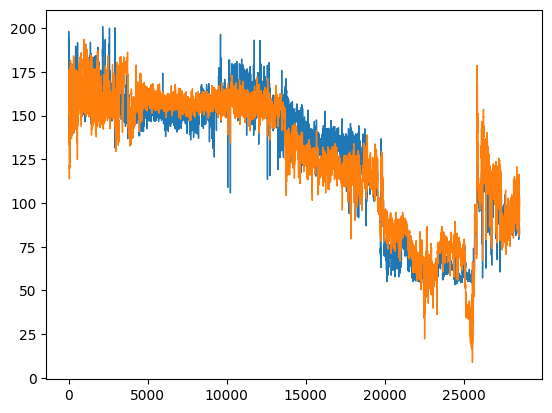

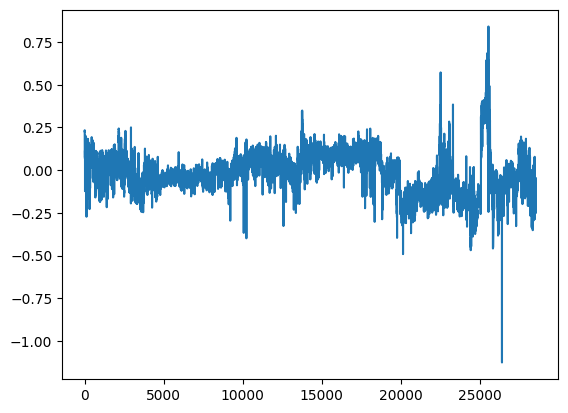

(143.4620167778298, 0.8995457829942496)

In [268]:
#split the data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

def dtc_linear_regression(X, Y, test_size=.2, random_state=42, log=False):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    # Train a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    # Make predictions
    y_pred = model.predict(X_test)
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    if log: print(f"Mean Squared Error: {mse}")
    if log: print(f"R^2 Score: {r2}")
    # Plot the predictions against the true values
    if log:
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        plt.title('True vs Predicted Values')
        plt.grid(True)
        plt.gca().set_aspect("equal")
        plt.show()

        plt.plot(Y, linewidth=1)
        plt.plot(model.predict(X), linewidth=1)
        plt.show()

        plt.plot((Y - model.predict(X))/Y)
        plt.show()
    
    return mse, r2

dtc_linear_regression(X, Y, log=True, random_state=42666)

In [12]:
np.random.seed(42)
test_seeds = np.random.randint(1, high=4294967295, size=1000, dtype=np.int64)
res = [dtc_linear_regression(X, Y, test_size=0.99, random_state=r) for r in test_seeds]

In [13]:
mses, r2s = zip(*res)
print(f"Mean mse: {np.mean(mses):.3f}, mean r2: {np.mean(r2s):.3f}")

Mean mse: 156.557, mean r2: 0.891


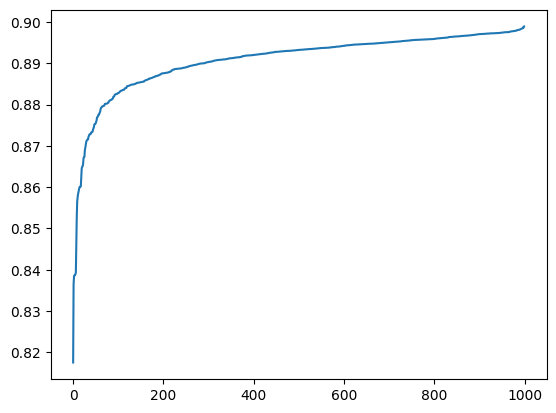

In [14]:
plt.plot(np.sort(r2s))

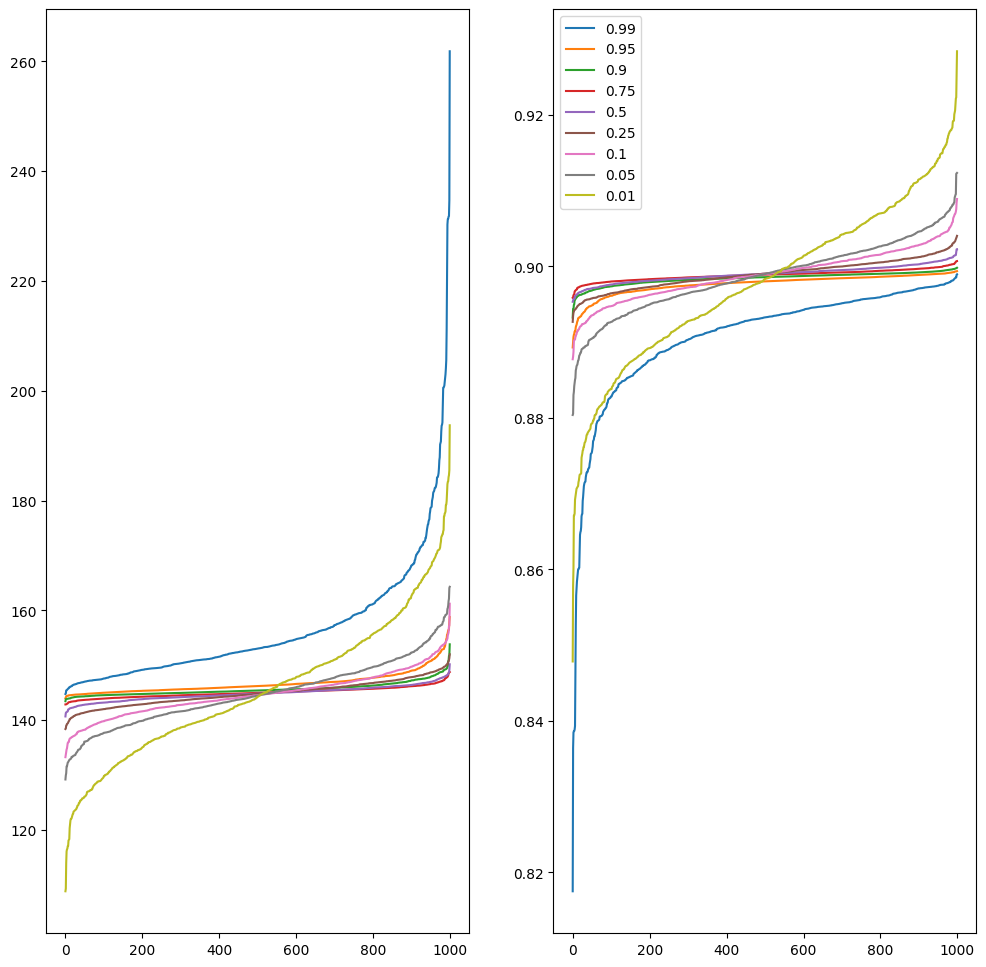

In [16]:
test_sizes = [.99, .95, .90, .75, .50, .25, .10, .05, .01]
plt.figure(figsize=(12,12))

for ts in test_sizes:
    np.random.seed(42)
    test_seeds = np.random.randint(1, high=4294967295, size=1000, dtype=np.int64)
    res = [dtc_linear_regression(X, Y, test_size=ts, random_state=r) for r in test_seeds]
    mses, r2s = zip(*res)
    # print(f"Mean mse: {np.mean(mses):.3f}, mean r2: {np.mean(r2s):.3f}")
    plt.subplot(1, 2, 1); plt.plot(np.sort(mses), label=f"{ts}")
    plt.subplot(1, 2, 2); plt.plot(np.sort(r2s), label=f"{ts}")

plt.legend()
plt.show()

Mean Squared Error: 342.6736497879447
R^2 Score: 0.7638074541815987


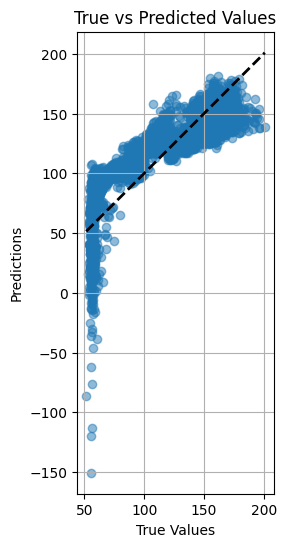

In [270]:
#split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=42)
# Train a linear regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)
# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
# Plot the predictions against the true values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.gca().set_aspect("equal")
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.grid(True)
plt.show()

## EMD

In [18]:
emd = EMD()
imfs_emd = emd(Y.DTC.to_numpy())

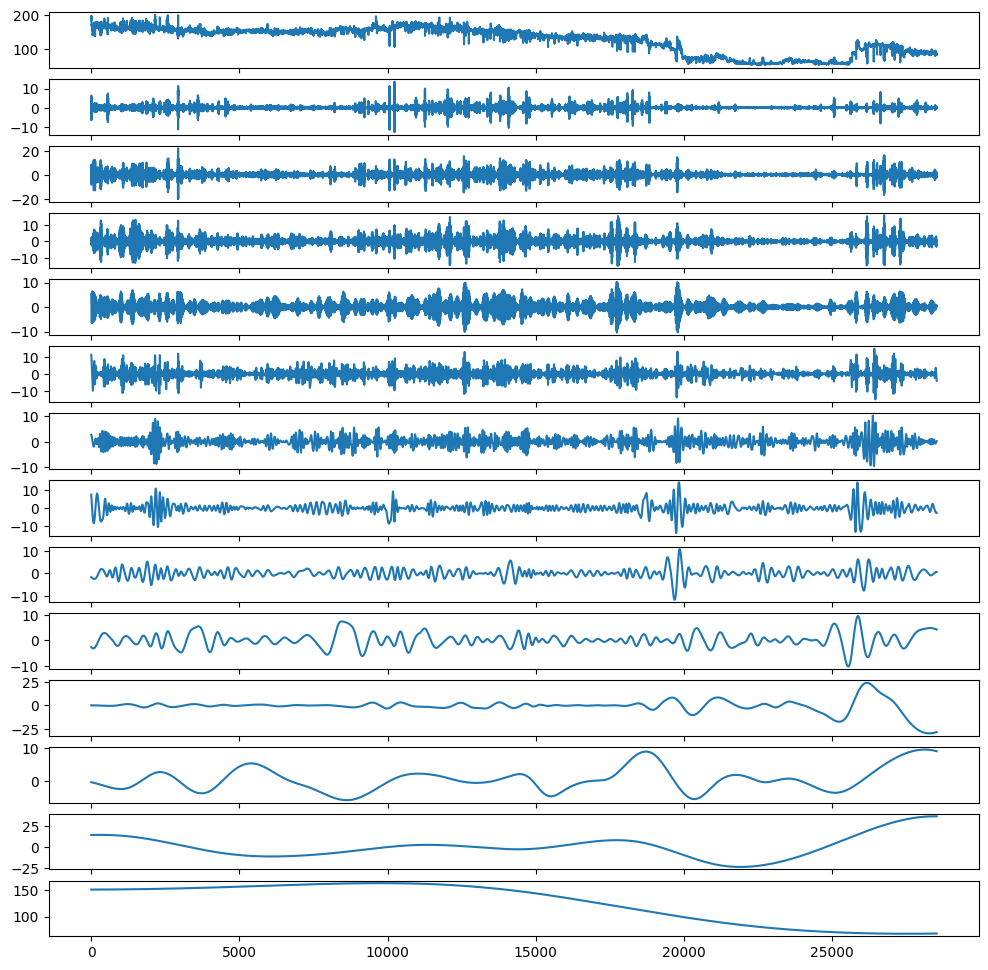

In [19]:
plt.figure(figsize=(12,12))
plt.subplot(imfs_emd.shape[0]+1, 1, 1); plt.plot(Y.DTC)

for i in range(imfs_emd.shape[0]):
    plt.subplot(imfs_emd.shape[0]+1, 1, i+2)
    plt.plot(imfs_emd[i, :])

plt.show()

## EWT

In [20]:
n_ewt_c = 5
ewt_output = EWT1D(Y.DTC, N = n_ewt_c)

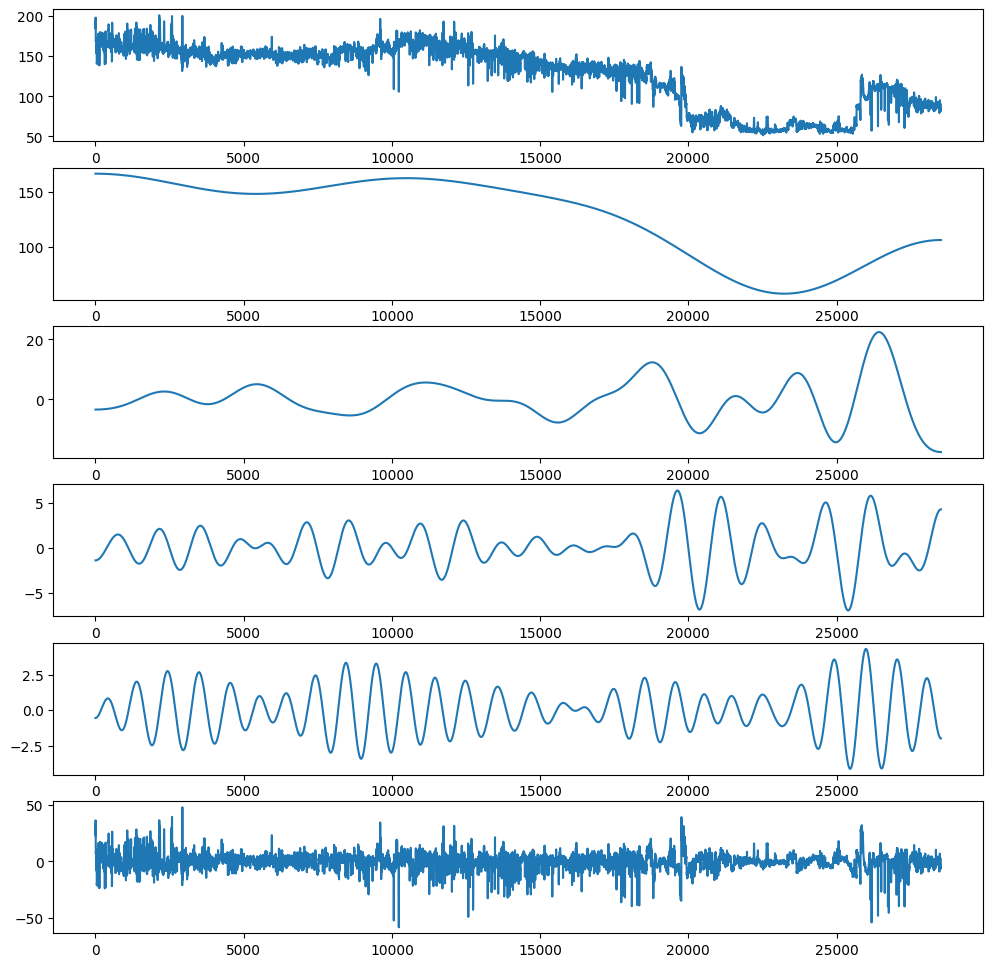

In [21]:
plt.figure(figsize=(12,12))
plt.subplot(n_ewt_c+1, 1, 1)
plt.plot(Y.DTC)

for i in range(n_ewt_c):
    plt.subplot(n_ewt_c + 1, 1, i+2)
    plt.plot(ewt_output[0][:, i])

plt.show()

## DFA

In [69]:
def detrended_fluctuation_analysis(signal, scales, order=1):
    N = len(signal)
    Y = np.cumsum(signal - np.mean(signal))
    F = []

    for s in scales:
        n_segments = N // s
        local_rms = []

        for i in range(n_segments):
            segment = Y[i*s:(i+1)*s]
            x = np.arange(s)
            coeffs = np.polyfit(x, segment, order)
            trend = np.polyval(coeffs, x)
            rms = np.sqrt(np.mean((segment - trend)**2))
            local_rms.append(rms)

        F.append(np.sqrt(np.mean(np.square(local_rms))))

    return np.array(F)

In [70]:
N = len(Y)
scales = np.unique(np.logspace(np.log10(4), np.log10(50), num=20, dtype=int))

dfa_dtc = detrended_fluctuation_analysis(Y.DTC.to_numpy(), scales)

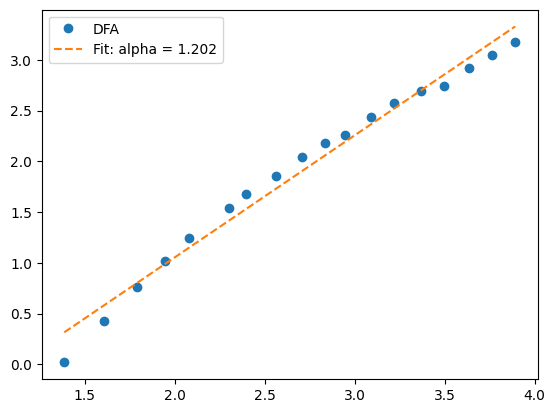

In [71]:
log_scales = np.log(scales)
log_F = np.log(dfa_dtc)

alpha, intercept = np.polyfit(log_scales, log_F, 1)

plt.plot(log_scales, log_F, 'o', label="DFA")
plt.plot(log_scales, np.polyval([alpha, intercept], log_scales), linestyle="--", label=f"Fit: alpha = {alpha:.3f}")
# plt.plot(log_scales, alpha*log_scales+intercept)
plt.legend(); plt.show()

## ARIMA?

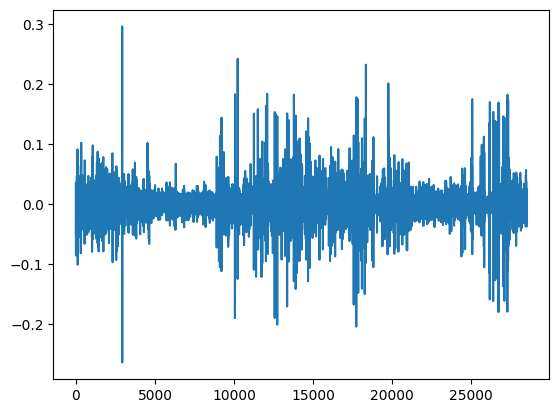

In [460]:
y = Y.DTC
log_y = np.log(y)
y_diff = np.diff(log_y)

plt.plot(y_diff)
dtc_diffed = y_diff
# dtc_diffed = np.diff(Y.DTC)
# plt.plot(dtc_diffed)

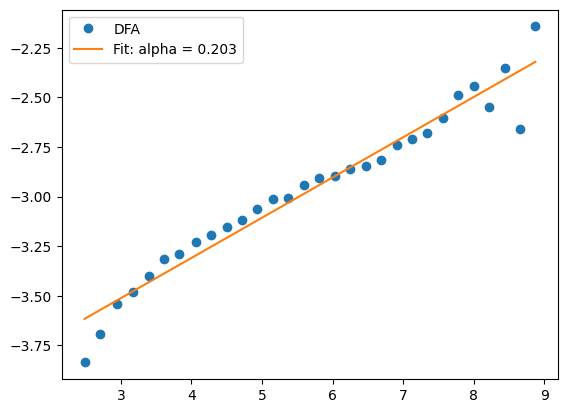

In [461]:
dfa_diffed_dtc = detrended_fluctuation_analysis(dtc_diffed, scales)
dtc_diffed_log_F = np.log(dfa_diffed_dtc)
dtc_diffed_poly = np.polyfit(log_scales, dtc_diffed_log_F, 1)

plt.plot(log_scales, dtc_diffed_log_F, 'o', label="DFA")
plt.plot(log_scales, np.polyval(dtc_diffed_poly, log_scales), label=f"Fit: alpha = {dtc_diffed_poly[0]:.3f}")
plt.legend(); plt.show()

In [462]:
from statsmodels.tsa.stattools import adfuller, acf, pacf

# adf = adfuller(dtc_diffed)
dtc_acf = acf(y_diff)
dtc_pacf = pacf(y_diff)

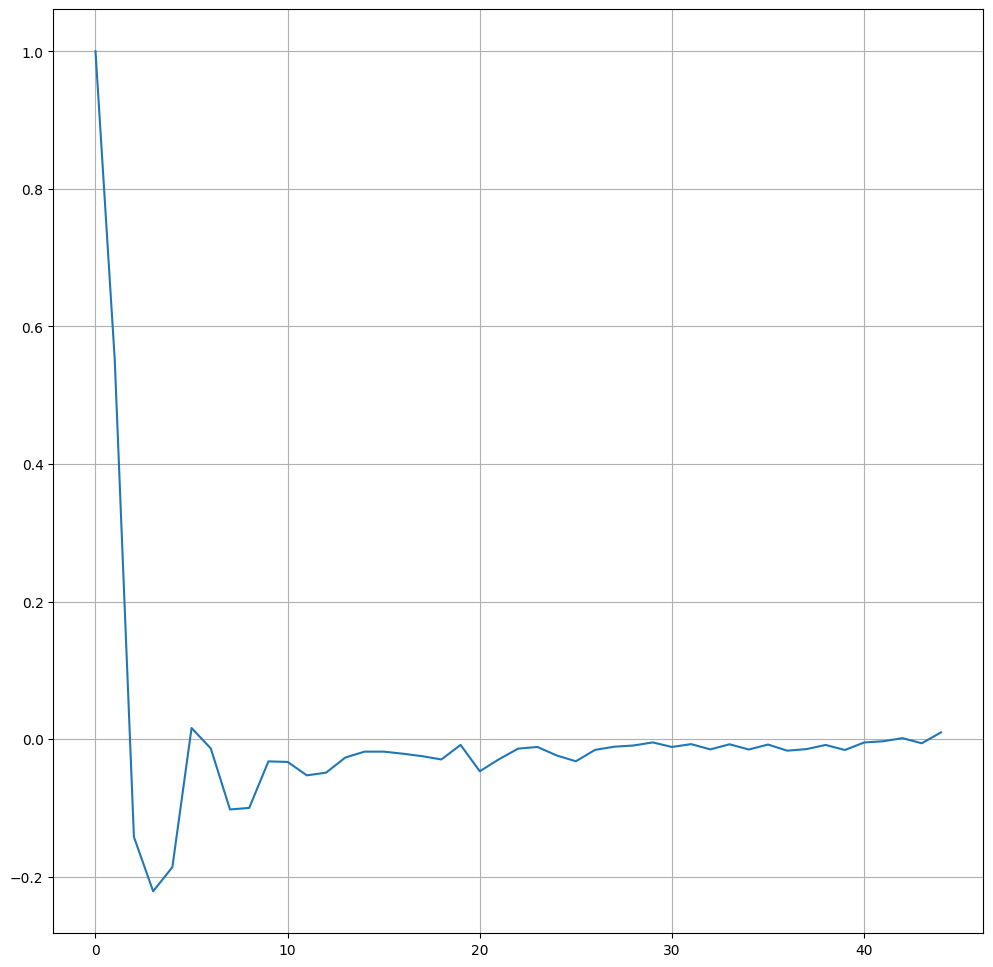

In [465]:
plt.figure(figsize=(12,12)); plt.grid(True)
# plt.plot(dtc_acf)
plt.plot(dtc_pacf)

## MSSA-DFA denoising

In [78]:
from tqdm import trange
# -----------------------
# MSSA Helper Functions
# -----------------------
def embed_time_series(X, M):
    L, N = X.shape
    K = N - M + 1
    trajectory = np.zeros((L * M, K))
    for l in range(L):
        for i in range(M):
            trajectory[l * M + i] = X[l, i:i + K]
    return trajectory

def compute_dfa(signal, min_scale=4, max_scale=50):
    N = len(signal)
    scales = np.floor(np.logspace(np.log10(min_scale), np.log10(max_scale), num=20)).astype(int)
    fluctuations = []
    profile = np.cumsum(signal - np.mean(signal))

    for scale in scales:
        segments = N // scale
        rms = []
        for i in range(segments):
            idx = slice(i * scale, (i + 1) * scale)
            segment = profile[idx]
            x = np.arange(scale)
            coeffs = np.polyfit(x, segment, deg=1)
            trend = np.polyval(coeffs, x)
            rms.append(np.sqrt(np.mean((segment - trend) ** 2)))
        fluctuations.append(np.mean(rms))

    log_scales = np.log(scales)
    log_flucts = np.log(fluctuations)
    slope, _ = np.polyfit(log_scales, log_flucts, 1)
    return slope

def mssa_dfa_dual_filter_denoise(X, M=30, dfa_threshold=0.8, variance_threshold=0.005, log=False):
    """
    Apply MSSA and retain only components that pass both DFA and variance thresholds.
    
    Parameters:
    - X: multivariate time series (L x N)
    - M: window size
    - dfa_threshold: minimum DFA exponent to consider a component as signal
    - variance_threshold: minimum explained variance ratio to consider significant
    """
    L, N = X.shape
    K = N - M + 1

    # 1. MSSA
    trajectory = embed_time_series(X, M)
    U, Sigma, VT = svd(trajectory, full_matrices=False)

    explained_variance = (Sigma ** 2) / np.sum(Sigma ** 2)

    if log: print("Setup complete")

    RCs = []
    dfa_exponents = []
    for k in trange(U.shape[1]):
        Uk = U[:, k].reshape((L, M))
        Sk = Sigma[k]
        Vk = VT[k, :]
        RC_k = np.zeros((L, N))
        for l in range(L):
            for i in range(K):
                RC_k[l, i:i + M] += Sk * Uk[l, :] * Vk[i]
        RC_k /= M

        # Compute average DFA for this RC
        avg_dfa = np.mean([compute_dfa(RC_k[l]) for l in range(L)])
        dfa_exponents.append(avg_dfa)
        RCs.append(RC_k)

    # 2. Apply dual filtering
    selected = []
    for k, (rc, alpha) in enumerate(zip(RCs, dfa_exponents)):
        if alpha > dfa_threshold and explained_variance[k] > variance_threshold:
            selected.append(rc)

    if not selected:
        print("No components passed both thresholds. Try lowering them.")
        return np.zeros_like(X), [], []

    denoised = np.sum(selected, axis=0)
    return denoised, dfa_exponents, explained_variance

In [74]:
X

RSHA     BS    RHOB   CALI    DRHO     GR    RDEP  CALI_corr
0      1.3217  14.75  1.8472  23.34  0.0415  33.95  3.9138       8.59
1      1.4145  14.75  1.7853  23.34  0.0357  31.84  2.9350       8.59
2      1.5729  14.75  1.7820  23.34  0.0483  30.36  2.2030       8.59
3      1.8115  14.75  1.8079  23.34  0.0615  29.72  2.0946       8.59
4      2.1879  14.75  1.8269  23.03  0.0703  28.82  4.1477       8.28
...       ...    ...     ...    ...     ...    ...     ...        ...
28519  1.0496   5.75  2.4412   4.94 -0.0613  83.46  0.7776      -0.81
28520  1.0746   5.75  2.4549   4.95 -0.0570  79.03  0.8469      -0.80
28521  1.0792   5.75  2.4624   4.96 -0.0545  74.84  0.8660      -0.79
28522  1.0952   5.75  2.4676   4.97 -0.0526  72.93  0.8353      -0.78
28523  1.0734   5.75  2.4754   4.96 -0.0512  71.48  0.7619      -0.79

[28524 rows x 8 columns]

In [185]:
dfa_thr, var_thr = .8, .005
# denoised, dfa_exponents, explained_var = mssa_dfa_dual_filter_denoise(
#     Y.DTC.to_numpy().reshape((len(Y), 1)).T, 
#     M=30, dfa_threshold=dfa_thr, variance_threshold=var_thr)
denoised, dfa_exponents, explained_var = mssa_dfa_dual_filter_denoise(
    X.to_numpy().T, M=30, dfa_threshold=dfa_thr, variance_threshold=var_thr
)

100%|██████████| 240/240 [31:42<00:00,  7.93s/it]


In [ ]:
explained_var

array([9.98681833e-01, 3.67461553e-04, 2.52398509e-04, 2.07943376e-04,
       1.61851697e-04, 1.03902069e-04, 7.16814119e-05, 5.21921802e-05,
       3.40885054e-05, 2.00688826e-05, 1.29196840e-05, 7.70736318e-06,
       4.59828194e-06, 2.93894189e-06, 1.91558230e-06, 1.50237936e-06,
       1.48802527e-06, 1.47326448e-06, 1.38141460e-06, 1.34400957e-06,
       1.32608707e-06, 1.25127473e-06, 1.14827389e-06, 1.00228574e-06,
       9.11386060e-07, 8.69206684e-07, 7.59773982e-07, 6.98260154e-07,
       6.96583939e-07, 6.47044172e-07])

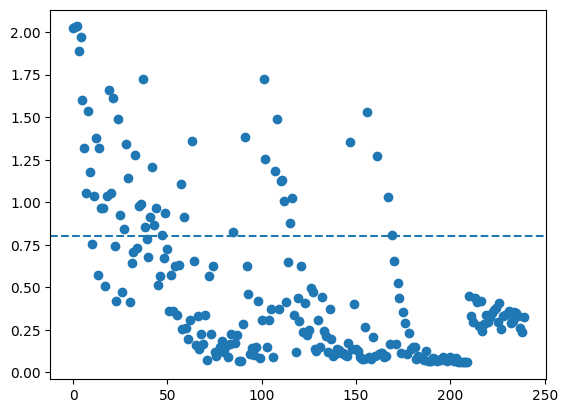

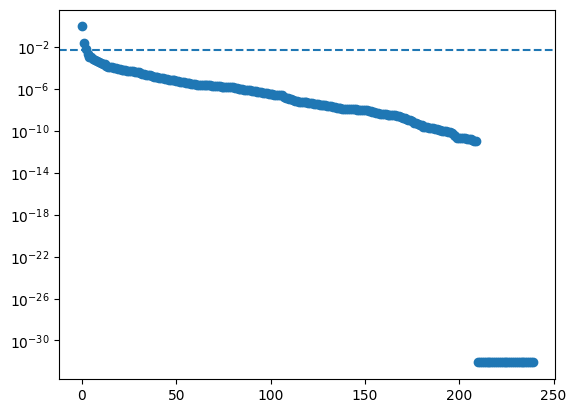

In [186]:
plt.scatter(range(len(dfa_exponents)), dfa_exponents)
plt.axhline(dfa_thr, color="tab:blue", linestyle="--")
plt.show()
plt.semilogy(explained_var, 'o')
plt.axhline(var_thr, linestyle="--")
plt.show()

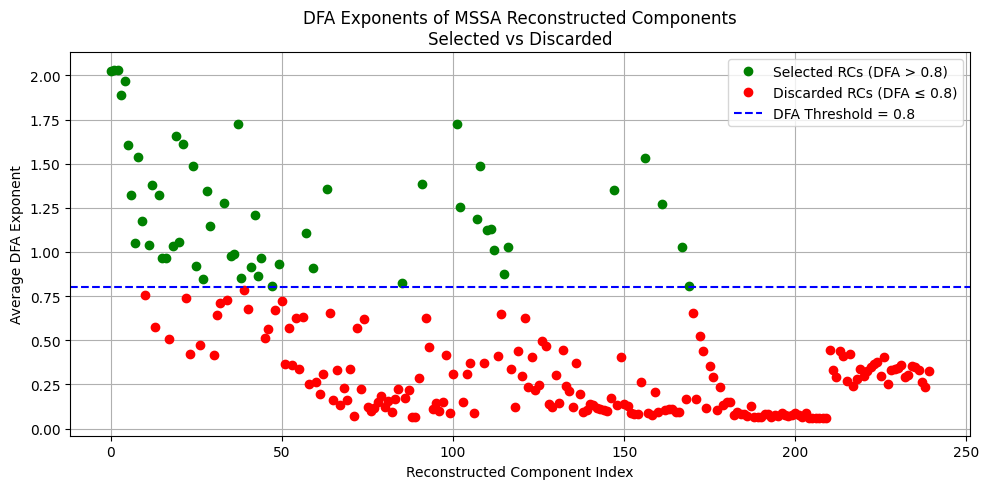

In [187]:
# Determine which RCs would be selected at threshold = 0.8
threshold = 0.8
selected_indices = [i for i, alpha in enumerate(dfa_exponents) if alpha > threshold]
discarded_indices = [i for i in range(len(dfa_exponents)) if i not in selected_indices]

# Plot with selected vs discarded RCs color-coded
plt.figure(figsize=(10, 5))
plt.plot(selected_indices, [dfa_exponents[i] for i in selected_indices], 'go', label='Selected RCs (DFA > 0.8)')
plt.plot(discarded_indices, [dfa_exponents[i] for i in discarded_indices], 'ro', label='Discarded RCs (DFA ≤ 0.8)')
plt.axhline(threshold, color='blue', linestyle='--', label='DFA Threshold = 0.8')
plt.xlabel("Reconstructed Component Index")
plt.ylabel("Average DFA Exponent")
plt.title("DFA Exponents of MSSA Reconstructed Components\nSelected vs Discarded")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

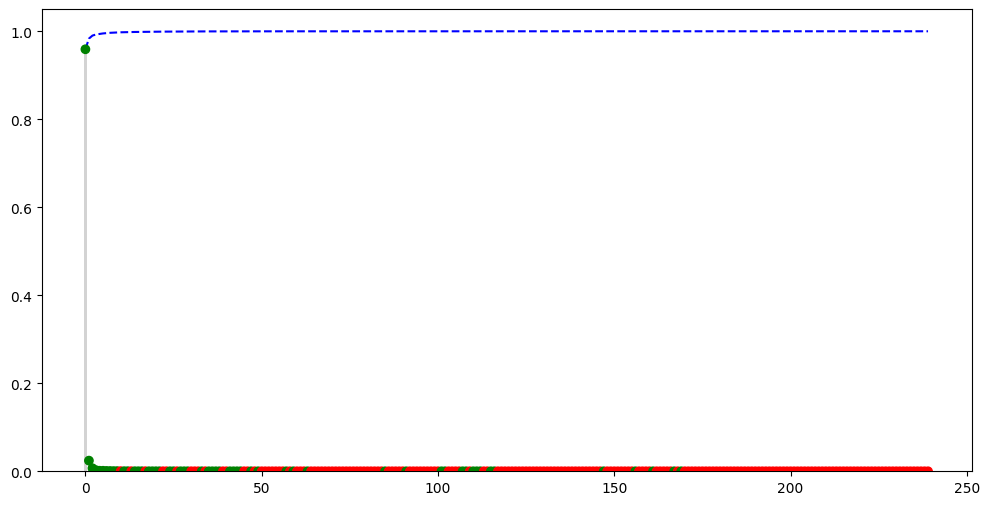

In [188]:
_ci = np.arange(len(dfa_exponents))
_cv = np.cumsum(explained_var)
plt.figure(figsize=(12,6))
plt.bar(_ci, explained_var, color="lightgray", label="Explained Variance")
plt.scatter(_ci, explained_var, c=["green" if a > dfa_thr else "red" for a in dfa_exponents], zorder=3)
plt.plot(_ci, _cv, color="blue", linestyle="--", label="Cumilative Variance")

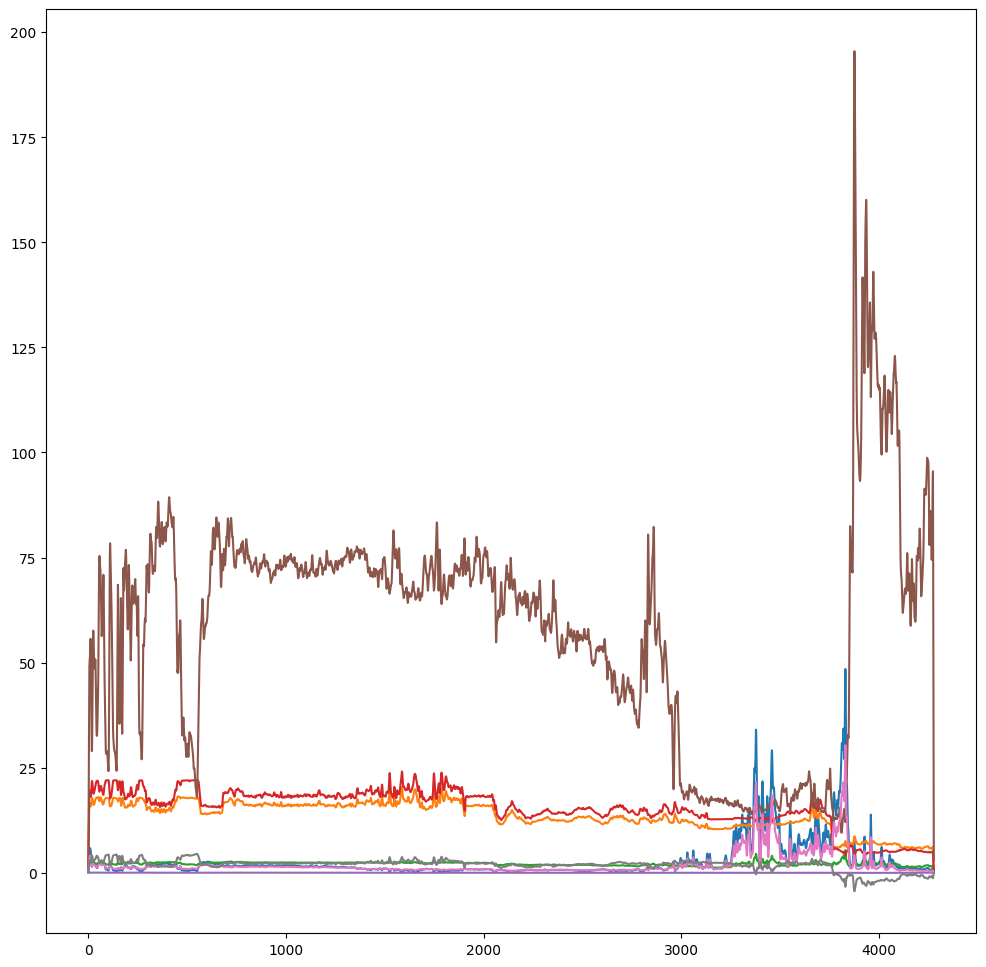

In [190]:
plt.figure(figsize=(12,12))
plt.plot(0.15 * np.arange(0, len(Y)), denoised.T)
# plt.plot(0.15 * np.arange(0, len(Y)), Y.DTC, linestyle="--", linewidth=1, alpha=0.5)
# plt.xlim(1000, 1300)

In [64]:
from time import time
def compute_dfa(signal, min_scale=4, max_scale=50):
    t0 = time()
    N = len(signal)
    scales = np.floor(np.logspace(np.log10(min_scale), np.log10(max_scale), num=20)).astype(int)
    fluctuations = []
    profile = np.cumsum(signal - np.mean(signal))
    t1 = time()
    print(f"Setup: {t1-t0:3f} s")

    for scale in scales:
        t2 = time()
        segments = N // scale
        rms = []
        for i in trange(segments):
            idx = slice(i * scale, (i + 1) * scale)
            segment = profile[idx]
            x = np.arange(scale)
            coeffs = np.polyfit(x, segment, deg=1)
            trend = np.polyval(coeffs, x)
            rms.append(np.sqrt(np.mean((segment - trend) ** 2)))
        fluctuations.append(np.mean(rms))
        t3 = time()
        print(f"Iteration for {scale}: {t3-t2:.3f} s")

    log_scales = np.log(scales)
    log_flucts = np.log(fluctuations)
    slope, _ = np.polyfit(log_scales, log_flucts, 1)
    return slope

def detrended_fluctuation_analysis(signal, scales, order=1):
    t0 = time()
    N = len(signal)
    # scales = np.floor(np.logspace(np.log10(min_scale), np.log10(max_scale), num=20)).astype(int)
    Y = np.cumsum(signal - np.mean(signal))
    F = []
    t1 = time()

    for s in scales:
        t2 = time()
        n_segments = N // s
        local_rms = []

        for i in trange(n_segments):
            segment = Y[i*s:(i+1)*s]
            x = np.arange(s)
            coeffs = np.polyfit(x, segment, order)
            trend = np.polyval(coeffs, x)
            rms = np.sqrt(np.mean((segment - trend)**2))
            local_rms.append(rms)

        F.append(np.sqrt(np.mean(np.square(local_rms))))
        t3 = time()
        print(f"Iteration for {s}: {t3-t2:.3f} s")

    return np.array(F)

## Power spectrum

In [27]:
from scipy.fft import fft, dct, idct, ifft

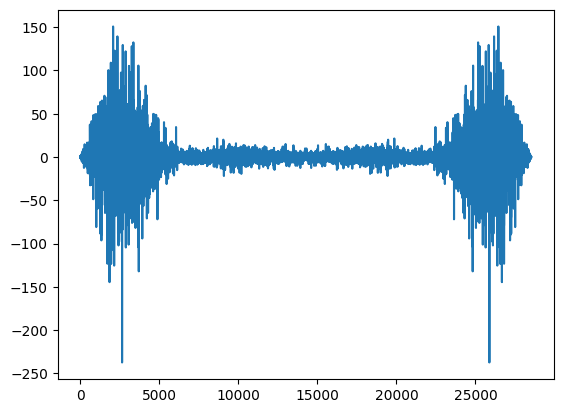

In [469]:
a = fft(y_diff)
# a = dct(Y.DTC)
# a = dct(y_diff)
plt.plot(a**2)

## PLS regression

In [191]:
#split the data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score

def dtc_regession_monte_carlo(X, Y, test_size=0.2, random_state=42, log=False):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    
    model = PLSRegression(n_components=2, scale=True)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    # Evaluate the model
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    if log: print(f"Mean Squared Error: {mse}")
    if log: print(f"R^2 Score: {r2}")
    # Plot the predictions against the true values
    if log:
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        plt.title('True vs Predicted Values')
        plt.grid(True)
        plt.show()

        plt.plot(Y)
        plt.plot(model.predict(X))
        plt.show()

        plt.plot((Y - model.predict(X))/(Y))
        plt.show()
    
    return mse, r2

In [193]:
np.random.seed(42)
test_seeds = np.random.randint(1, high=4294967295, size=1000, dtype=np.int64)
res = [dtc_regession_monte_carlo(denoised.T, Y, test_size=.2, random_state=r) for r in test_seeds]

In [194]:
mses, r2s = zip(*res) 
print(f"Mean mse: {np.mean(mses):.3f}, mean r2: {np.mean(r2s):.3f}")

Mean mse: 263.047, mean r2: 0.816


## RPCA

In [33]:
from rpca import RobustPCA

rpca = RobustPCA(0.1)

L, S = rpca.fit(X.to_numpy())

<Axes: >

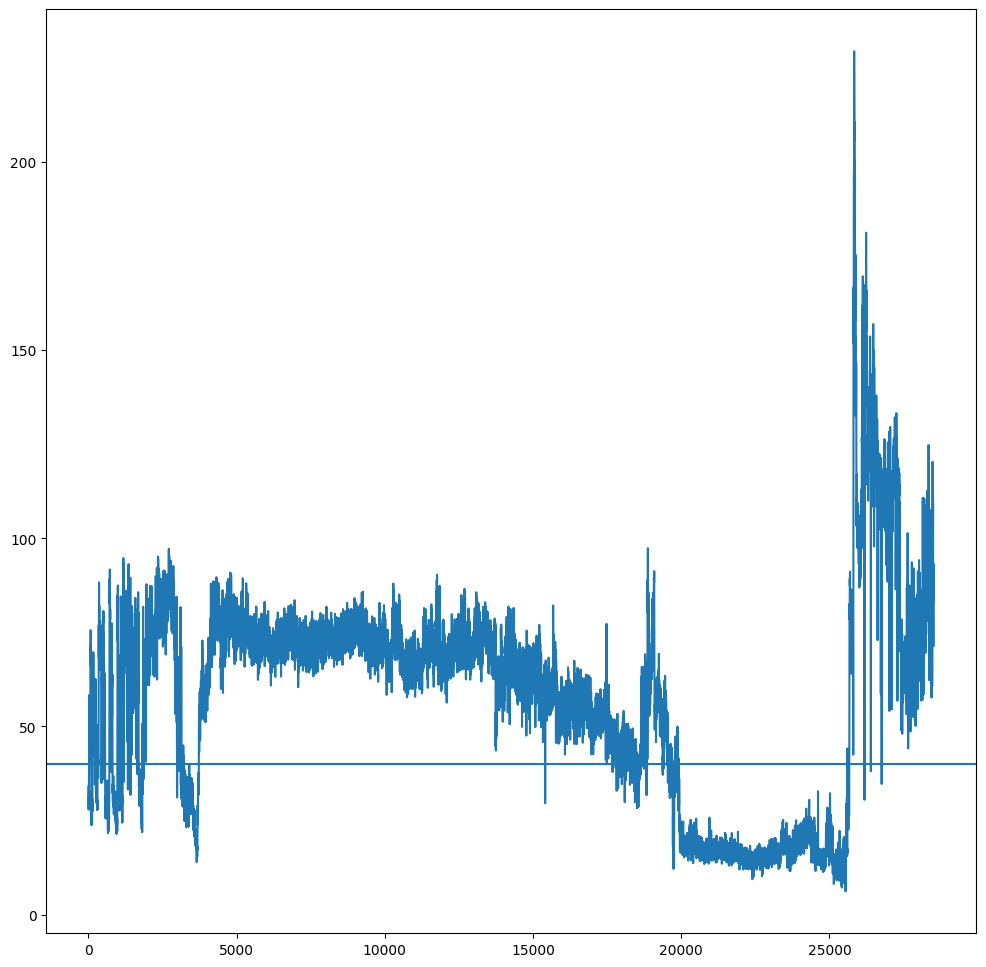

In [34]:
plt.figure(figsize=(12,12))
plt.axhline(40)
X.GR.plot()

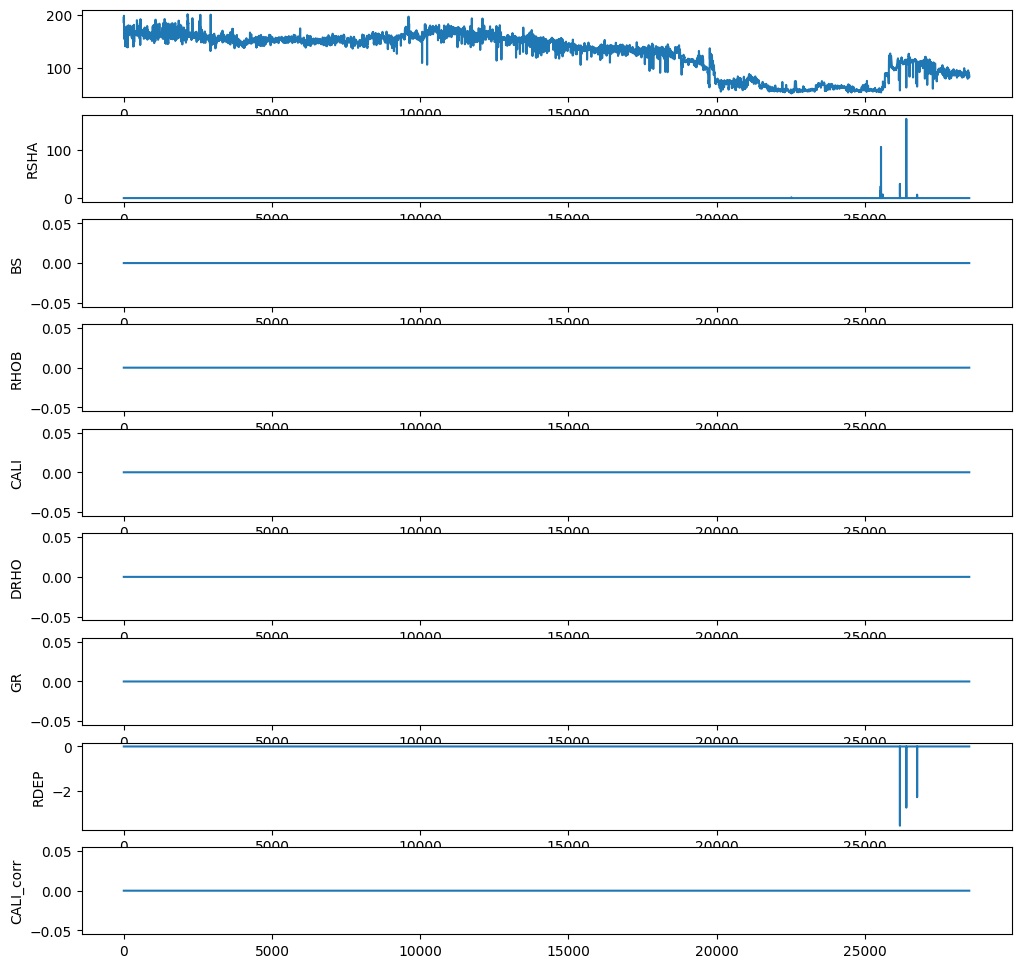

In [35]:
plt.figure(figsize=(12,12))
plt.subplot(len(X.columns)+1, 1, 1)
plt.plot(Y)
for i, c in enumerate(X.columns):
    plt.subplot(len(X.columns)+1, 1, i+2)
    plt.plot(S[:, i])
    plt.ylabel(c)

plt.show()

Mean Squared Error: 144.8370942550962
R^2 Score: 0.9001690324242304


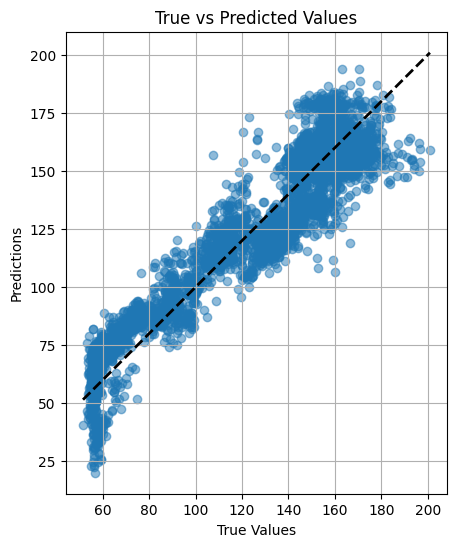

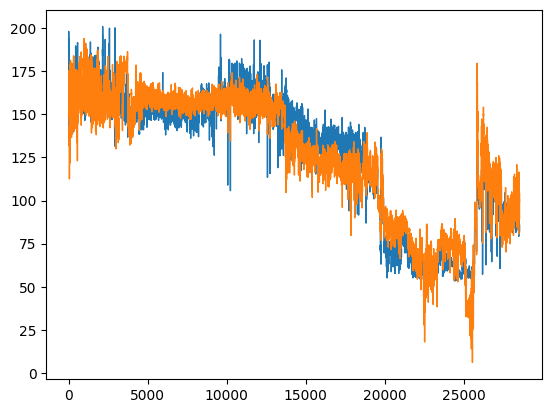

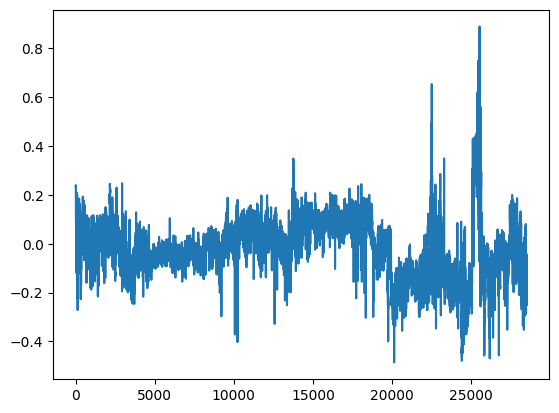

(144.8370942550962, 0.9001690324242304)

In [271]:
dtc_linear_regression(L, Y, log=True)

## Other regressors

Testing:
- Support Vector Regressor
- Random Forest
- Gradient Boosting
- K-nearest-neighbors regressor

In [195]:
X_train, X_test, Y_train, Y_test = train_test_split(denoised.T, Y, test_size=.2, random_state=42)

In [196]:
X_train.shape

(22819, 8)

### SVR

In [ ]:
from sklearn.svm import SVR

svr = SVR(verbose=3)
svr.fit(X_train, Y_train)

c:\Users\bjrna\.virtualenvs\ham-EtQshisQ\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TypeError: 'numpy.ndarray' object does not support the context manager protocol

In [51]:
Y_train_pred = svr.predict(X_train)
Y_test_pred = svr.predict(X_test)
Y_pred = svr.predict(X)

In [272]:
print(f"RMSE: {mean_squared_error(Y_test, Y_test_pred)}\nR2  : {r2_score(Y_test, Y_test_pred)}")

plt.scatter(Y_test, Y_test_pred, alpha=.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)
plt.gca().set_aspect("equal")
plt.show()

plt.plot(Y)
plt.plot(Y_pred)
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [5705, 5001]

### RF regressor

/home/bjornoka/.local/share/virtualenvs/ham-nl-vQ_QP/lib64/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE: 8.57411756553549
R2  : 0.9940901710499092


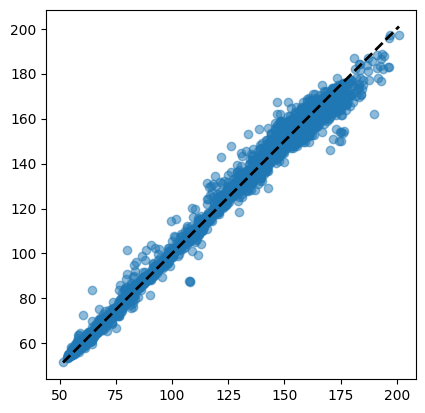

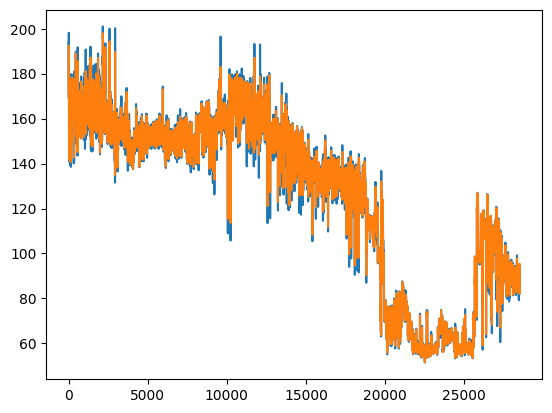

In [198]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(X_train, Y_train)

Y_train_pred = rfr.predict(X_train)
Y_test_pred = rfr.predict(X_test)
Y_pred = rfr.predict(denoised.T)

print(f"RMSE: {mean_squared_error(Y_test, Y_test_pred)}\nR2  : {r2_score(Y_test, Y_test_pred)}")

plt.scatter(Y_test, Y_test_pred, alpha=.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)
plt.gca().set_aspect("equal")
plt.show()

plt.plot(Y)
plt.plot(Y_pred)
plt.show()

### Gradient Boost regressor

/home/bjornoka/.local/share/virtualenvs/ham-nl-vQ_QP/lib64/python3.13/site-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


RMSE: 43.60501157636488
R2  : 0.9699446435375586


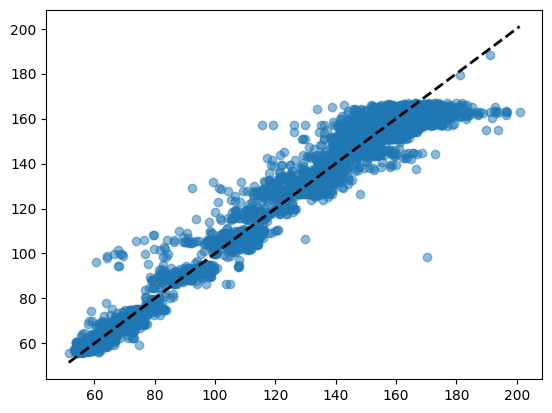

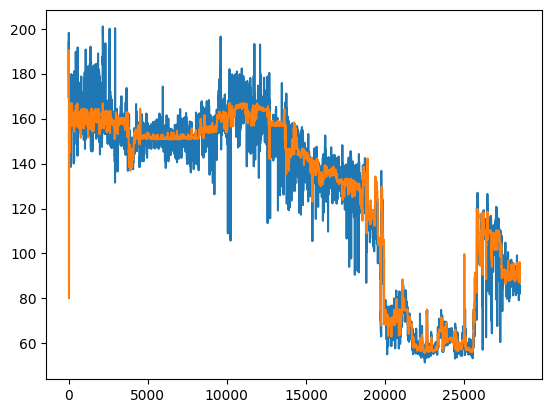

In [199]:
from sklearn.ensemble import GradientBoostingRegressor

grr = GradientBoostingRegressor()
grr.fit(X_train, Y_train)

Y_train_pred = grr.predict(X_train)
Y_test_pred = grr.predict(X_test)
Y_pred = grr.predict(denoised.T)

print(f"RMSE: {mean_squared_error(Y_test, Y_test_pred)}\nR2  : {r2_score(Y_test, Y_test_pred)}")

plt.scatter(Y_test, Y_test_pred, alpha=.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)
plt.show()

plt.plot(Y)
plt.plot(Y_pred)
plt.show()

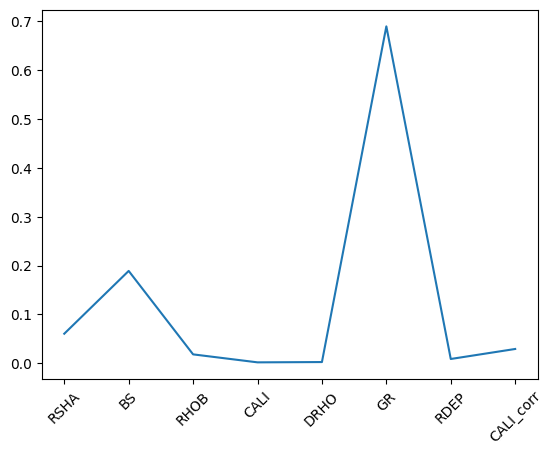

In [200]:
plt.plot(grr.feature_importances_)
plt.xticks(range(len(grr.feature_importances_)), X.columns[:len(grr.feature_importances_)], rotation=45)
plt.show()

### KNN regressor

RMSE: 22.631431429973706
R2  : 0.9844009733217949


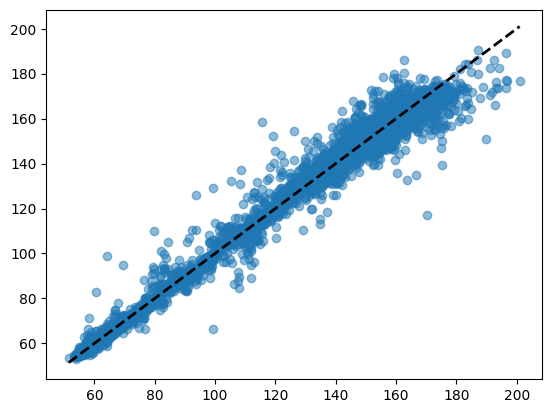

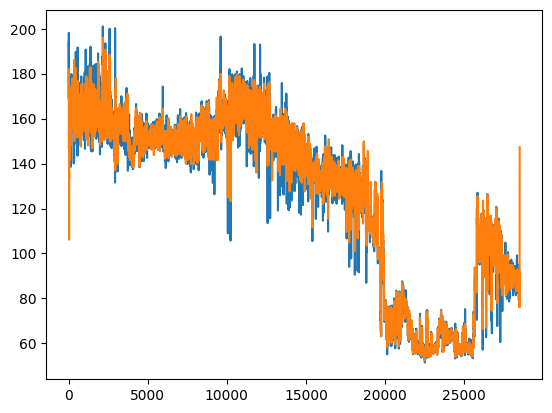

In [202]:
from sklearn.neighbors import KNeighborsRegressor

knr = KNeighborsRegressor()
knr.fit(X_train, Y_train)

Y_train_pred = knr.predict(X_train)
Y_test_pred = knr.predict(X_test)
Y_pred = knr.predict(denoised.T)

print(f"RMSE: {mean_squared_error(Y_test, Y_test_pred)}\nR2  : {r2_score(Y_test, Y_test_pred)}")

plt.scatter(Y_test, Y_test_pred, alpha=.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)
plt.show()

plt.plot(Y)
plt.plot(Y_pred)
plt.show()

### Stacking regressor?

In [ ]:
# from sklearn.ensemble import StackingRegressor

# sr = StackingRegressor()
# sr.fit(X_train, Y_train)

# Y_train_pred = sr.predict(X_train)
# Y_test_pred = sr.predict(X_test)
# Y_pred = sr.predict(X)

# print(f"RMSE: {mean_squared_error(Y_test, Y_test_pred)}\nR2  : {r2_score(Y_test, Y_test_pred)}")

# plt.scatter(Y_test, Y_test_pred, alpha=.5)
# plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)
# plt.show()

# plt.plot(Y)
# plt.plot(Y_pred)
# plt.show()

## Reconstruct missing block

In [203]:
def get_sections(Y):
    sections = np.split(Y, np.where(np.isnan(Y.values))[0])
    sections = [sec.dropna() for sec in filter(lambda arr: len(arr) > 2, sections)]
    if len(sections) < 1:
        return None
    else:
        return sections

In [204]:
def remove_data(data, block_starts: list[int], block_lengths: list[int]):
    """
    Removes sections of the inputted data, defined by the start and length of "missing" sections.
    
    Input:
    - data: contiguous data we'd like to put holes in
    - block_starts: indexes for where missing block should start
    - block_lengths: length of the missing sections

    Output:
    - data_hole: data with missing sections
    - data_no_hole: the missing sections
    """
    data_mnar = data.copy()
    removed_sections = []
    for s, l in zip(block_starts, block_lengths):
        data_mnar.loc[s:s+l] = None
        removed_sections.append(data.loc[s:s+l].copy())

    return data_mnar, pd.concat(removed_sections).reindex_like(data)

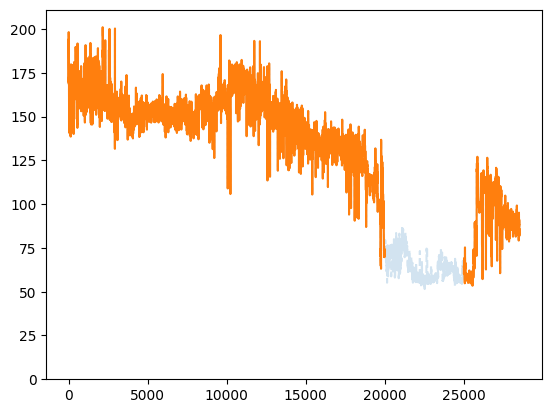

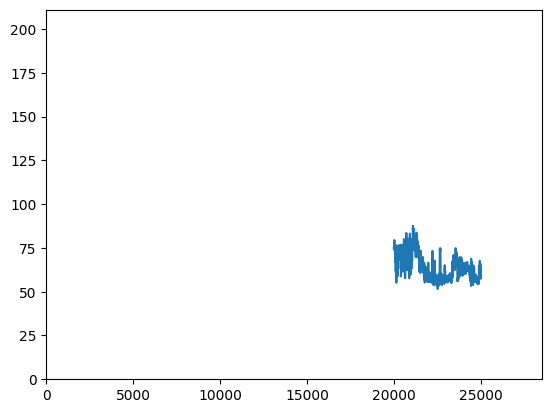

In [213]:
X_hole, X_no_hole = remove_data(pd.DataFrame(denoised.T), [20000], [5000])
Y_hole, Y_no_hole = remove_data(Y, [20000], [5000])
plt.plot(Y, linestyle="--", alpha=.2)
plt.plot(Y_hole); plt.ylim(0, Y.DTC.max() + 10)
plt.show()
plt.plot(Y_no_hole); plt.xlim(0, len(Y)); plt.ylim(0, Y.DTC.max() + 10)
plt.show()

In [207]:
(Y.DTC.to_numpy() - Y_pred.T).shape

(1, 28524)

/home/bjornoka/.local/share/virtualenvs/ham-nl-vQ_QP/lib64/python3.13/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE: 2928.4882289370594
R2  : -51.379333743649845


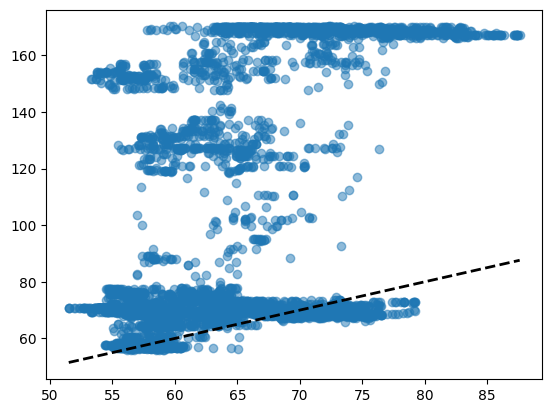

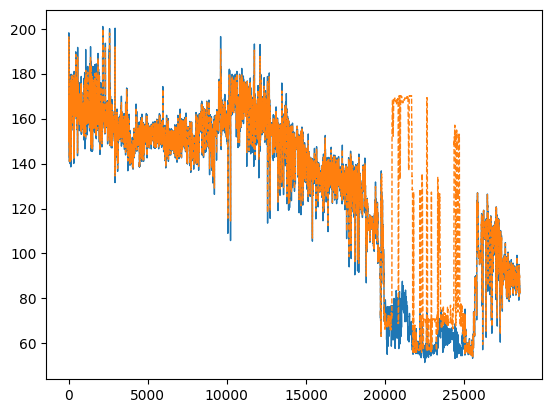

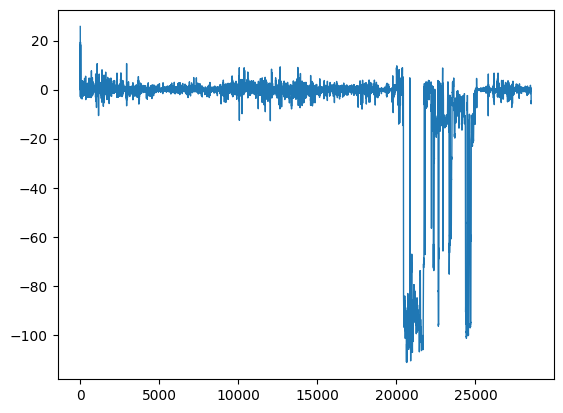

In [208]:
reg = RandomForestRegressor()
# reg = GradientBoostingRegressor()
# reg = KNeighborsRegressor()
# reg = LinearRegression()
# reg = SVR()
reg.fit(X_hole.dropna(), Y_hole.dropna())

Y_train_pred = reg.predict(X_hole.dropna())
Y_test_pred = reg.predict(X_no_hole.dropna())
Y_pred = reg.predict(denoised.T)

print(f"RMSE: {mean_squared_error(Y_no_hole.dropna(), Y_test_pred)}\nR2  : {r2_score(Y_no_hole.dropna(), Y_test_pred)}")

plt.scatter(Y_no_hole.dropna(), Y_test_pred, alpha=.5)
plt.plot([Y_no_hole.min(), Y_no_hole.max()], [Y_no_hole.min(), Y_no_hole.max()], 'k--', lw=2)
plt.show()

plt.plot(Y, linewidth=1)
plt.plot(Y_pred, linestyle="--", linewidth=1)
plt.show()

plt.plot(Y.DTC - Y_pred.reshape((len(Y),)), linewidth=1)
plt.show()

Text(0.5, 1.0, 'R2 score: -131.736')

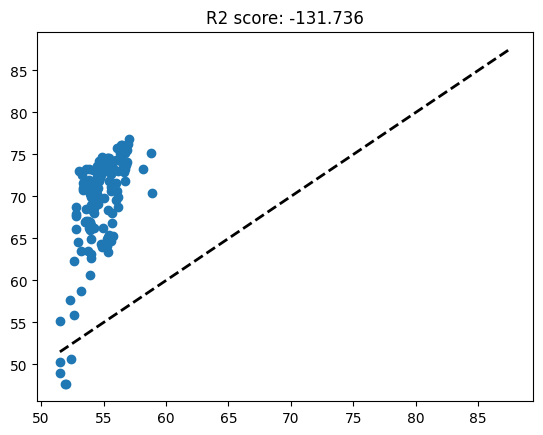

In [298]:
diff = Y_no_hole.DTC.dropna() - Y_test_pred.reshape((len(Y_no_hole.DTC.dropna()),))
# diff.plot()
level = -20
no_hole_r2_score = r2_score(Y_no_hole.DTC.dropna()[diff > level], Y_test_pred[diff > level])
plt.scatter(Y_no_hole.DTC.dropna()[diff > level], Y_test_pred[diff > level])
plt.plot([Y_no_hole.min(), Y_no_hole.max()], [Y_no_hole.min(), Y_no_hole.max()], 'k--', lw=2)
plt.title(f"R2 score: {no_hole_r2_score:.3f}")

In [282]:
rpca_dtc = RobustPCA(0.1)
L_dtc, S_dtc = rpca_dtc.fit(np.hstack((Y_no_hole.dropna().to_numpy(), Y_test_pred.reshape(len(Y_test_pred), 1))))
print(np.sum(S_dtc))

0.0


In [262]:
def find_overlap_sections(*arrays):
    # Convert all inputs to boolean masks of valid (non-NaN) values
    masks = [~np.isnan(arr) for arr in arrays]
    
    # Combine all masks with logical AND
    combined_mask = np.logical_and.reduce(masks)

    # Pad and diff to find block edges
    padded = np.pad(combined_mask.astype(int), (1, 1), constant_values=0)
    diff = np.diff(padded)

    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0]

    # Combine into list of (start, end) tuples
    return list(zip(starts, ends))

# Example usage
a = np.array([np.nan, 1.0, 2.0, 3.0, np.nan, np.nan, 4.0])
b = np.array([np.nan, 10.0, 11.0, 12.0, 13.0, np.nan, np.nan])
c = np.array([np.nan, 100.0, 101.0, 102.0, np.nan, np.nan, 103.0])

overlapping_sections = find_overlap_sections(a, b, c)

print("Overlapping valid sections (start, end):", overlapping_sections)


Overlapping valid sections (start, end): [(np.int64(1), np.int64(4))]


## Other feature combinations

In [211]:
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

len(list(filter(lambda a: len(a) > 4, powerset(X.columns))))

93

c:\Users\bjrna\.virtualenvs\ham-EtQshisQ\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE: 52.35038086320933
R2  : 0.06365405749419661


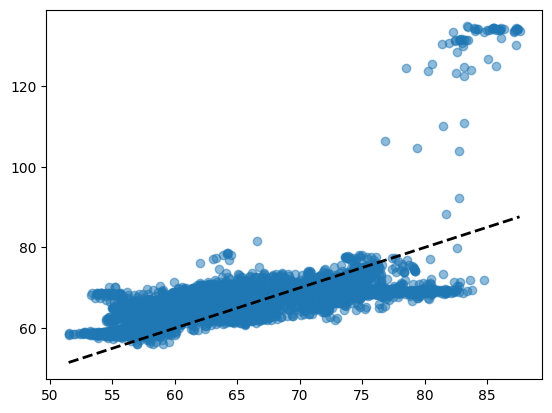

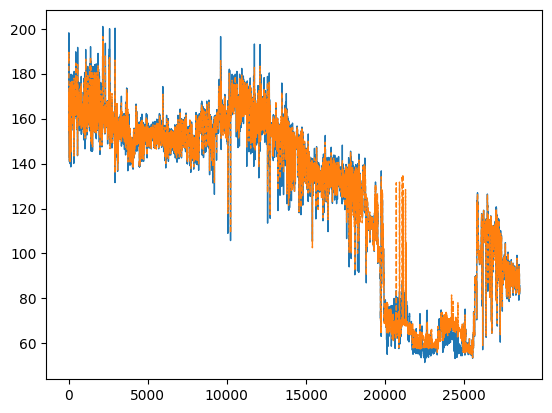

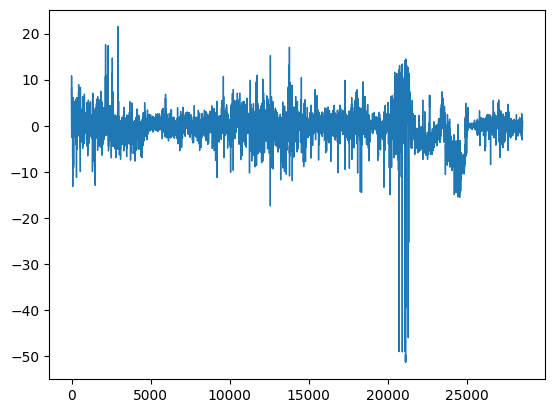

In [337]:
reg = RandomForestRegressor()
# reg = GradientBoostingRegressor()
# reg = KNeighborsRegressor()
# reg = LinearRegression()
# reg = SVR()
reg.fit(X_hole.dropna(), Y_hole.dropna())

Y_train_pred = reg.predict(X_hole.dropna())
Y_test_pred = reg.predict(X_no_hole.dropna())
Y_pred = reg.predict(X)

print(f"RMSE: {mean_squared_error(Y_no_hole.dropna(), Y_test_pred)}\nR2  : {r2_score(Y_no_hole.dropna(), Y_test_pred)}")

plt.scatter(Y_no_hole.dropna(), Y_test_pred, alpha=.5)
plt.plot([Y_no_hole.min(), Y_no_hole.max()], [Y_no_hole.min(), Y_no_hole.max()], 'k--', lw=2)
plt.show()

plt.plot(Y, linewidth=1)
plt.plot(Y_pred, linestyle="--", linewidth=1)
plt.show()

plt.plot(Y.DTC - Y_pred.reshape((len(Y),)), linewidth=1)
plt.show()

In [278]:
def train_regressor_with_missing_data(reg, features, X, Y,
                                      X_hole, Y_hole, X_no_hole, Y_no_hole,
                                      log=False):
    masked_training_data = X_hole[list(features)].dropna()
    masked_training_target = Y_hole.dropna()
    masked_data = X[list(features)]
    masked_target = Y
    masked_test_data = X_no_hole[list(features)].dropna()
    masked_test_target = Y_no_hole.dropna()

    reg.fit(masked_training_data, masked_training_target.DTC)

    Y_train_pred = reg.predict(masked_training_data)
    Y_test_pred = reg.predict(masked_test_data)
    Y_pred = reg.predict(masked_data)

    mse = mean_squared_error(masked_test_target, Y_test_pred)
    r2 = r2_score(masked_test_target, Y_test_pred)

    if log:
        print(f"RMSE: {mse:.3f}\nR2  : {r2:.3f}")

        plt.scatter(masked_test_target, Y_test_pred, alpha=.5)
        plt.plot([masked_test_target.min(), masked_test_target.max()], [masked_test_target.min(), masked_test_target.max()], 'k--', lw=2)
        plt.show()

        plt.plot(masked_target, linewidth=1)
        plt.plot(Y_pred, linestyle="--", linewidth=1)
        plt.show()

        plt.plot(masked_target.DTC - Y_pred.reshape((len(masked_target),)), linewidth=1)
        plt.show()
    
    data = {"gt_test": masked_test_target, "gt_training": masked_training_target, "training": Y_train_pred, "test": Y_test_pred, "all": Y_pred}
    
    return mse, r2, data

In [ ]:
features = list(combinations(X.columns, r=7))[0]
reg = RandomForestRegressor(random_state=42, n_jobs=-1)
mse, r2, res = train_regressor_with_missing_data(reg, features, pd.DataFrame(denoised.T, columns=X.columns), Y, X_hole, Y_hole, X_no_hole, Y_no_hole)

KeyError: "None of [Index(['RSHA', 'BS', 'RHOB', 'CALI', 'DRHO', 'GR', 'RDEP'], dtype='object')] are in the [columns]"

In [369]:
results = {8: [], 7: [], 6: [], 5: [], 4: [], 3: [], 2: [], 1: []}

for i in [8, 7, 6, 5, 4, 3, 2, 1]:
    print(f"\nFor {i} features")
    for fts in combinations(X.columns, r=i):
        reg = RandomForestRegressor(random_state=42, n_jobs=-1)
        mse, r2 = train_regressor_with_missing_data(reg, fts, X, Y, X_hole, Y_hole, X_no_hole, Y_no_hole)
        results[i].append((fts, mse, r2))
        print(results[i][-1])



For 8 features
(('RSHA', 'BS', 'RHOB', 'CALI', 'DRHO', 'GR', 'RDEP', 'CALI_corr'), 48.86898117947609, 0.12592283977149088)

For 7 features
(('RSHA', 'BS', 'RHOB', 'CALI', 'DRHO', 'GR', 'RDEP'), 44.34667099326332, 0.20680948708505165)
(('RSHA', 'BS', 'RHOB', 'CALI', 'DRHO', 'GR', 'CALI_corr'), 75.94298543696053, -0.35832643627716254)
(('RSHA', 'BS', 'RHOB', 'CALI', 'DRHO', 'RDEP', 'CALI_corr'), 431.87426429323176, -6.724561089637426)
(('RSHA', 'BS', 'RHOB', 'CALI', 'GR', 'RDEP', 'CALI_corr'), 45.9254525714376, 0.17857118775559422)
(('RSHA', 'BS', 'RHOB', 'DRHO', 'GR', 'RDEP', 'CALI_corr'), 40.87428841536488, 0.2689169881964335)
(('RSHA', 'BS', 'CALI', 'DRHO', 'GR', 'RDEP', 'CALI_corr'), 244.422769816445, -3.371778485655658)
(('RSHA', 'RHOB', 'CALI', 'DRHO', 'GR', 'RDEP', 'CALI_corr'), 48.9476869703499, 0.12451509742613953)
(('BS', 'RHOB', 'CALI', 'DRHO', 'GR', 'RDEP', 'CALI_corr'), 40.98635057057387, 0.2669126294389955)

For 6 features
(('RSHA', 'BS', 'RHOB', 'CALI', 'DRHO', 'GR'), 71.

In [436]:
df = pd.DataFrame()
ftss, mses, r2s = zip(*results[8], *results[7], *results[6], *results[5], *results[4], *results[3], *results[2], *results[1])

df["features"] = ftss
df["MSE"] = mses
df["R2"] = r2s

In [437]:
df.sort_values("MSE").head(10)

features        MSE        R2
132                   (BS, RHOB, DRHO, GR)  23.400160  0.581462
203                       (RHOB, DRHO, GR)  24.777224  0.556831
78              (BS, RHOB, DRHO, GR, RDEP)  26.426408  0.527334
154                 (RHOB, DRHO, GR, RDEP)  26.851214  0.519736
135                   (BS, RHOB, GR, RDEP)  28.486908  0.490479
186                         (BS, RHOB, GR)  28.683461  0.486964
206                       (RHOB, GR, RDEP)  29.316802  0.475636
234                             (RHOB, GR)  29.946844  0.464367
115                 (RSHA, RHOB, GR, RDEP)  29.958659  0.464155
34   (BS, RHOB, DRHO, GR, RDEP, CALI_corr)  31.990047  0.427822

RMSE: 24.777
R2  : 0.557


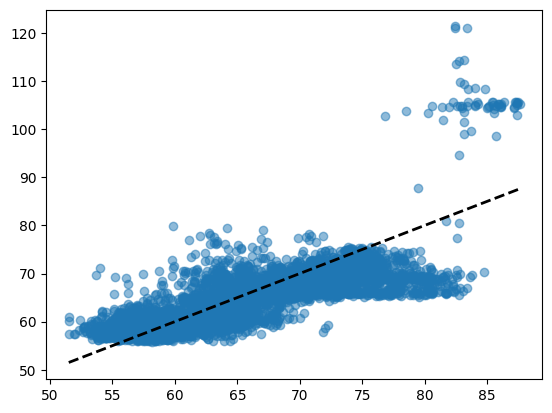

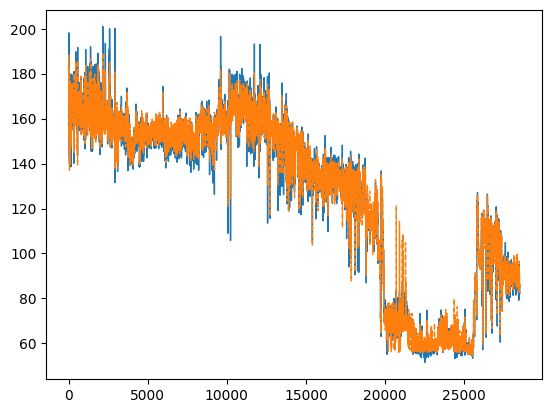

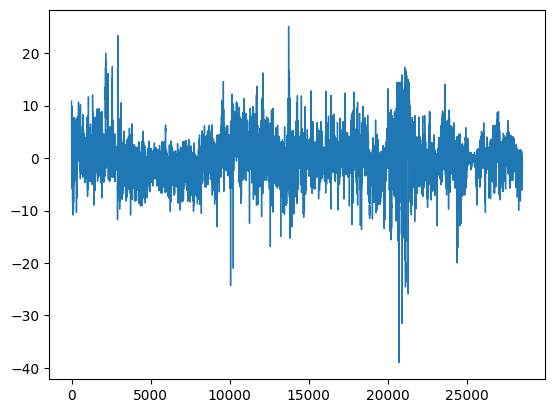

In [393]:
mse, r2 = train_regressor_with_missing_data(reg, ["RHOB", "DRHO", "GR"], X, Y, X_hole, Y_hole, X_no_hole, Y_no_hole, log=True)

## Missing block scenarios

### Missing sandstone? layer

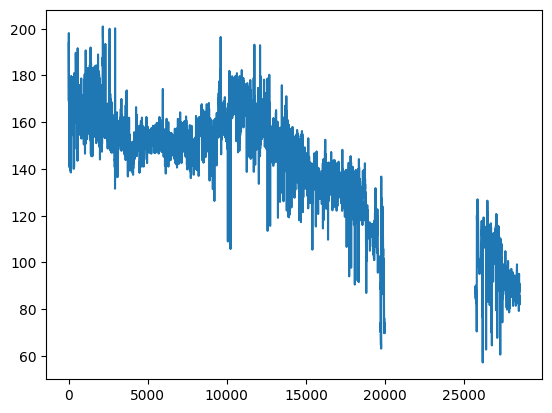

In [270]:
X_missing_sandstone, X_sandstone = remove_data(X, [20000], [5700])
Y_missing_sandstone, Y_sandstone = remove_data(Y, [20000], [5700])
plt.plot(Y_missing_sandstone)

RMSE: 788.628
R2  : -13.111


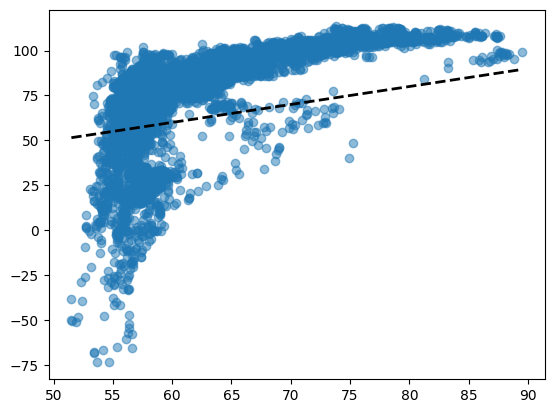

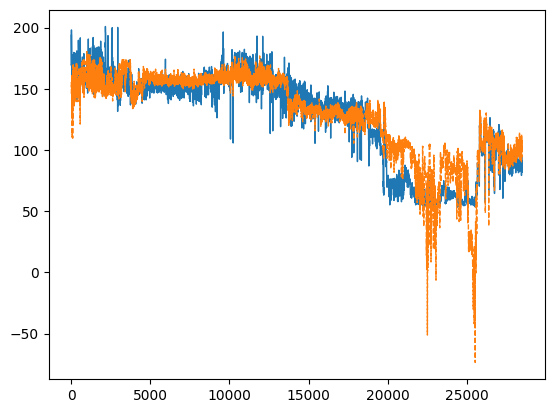

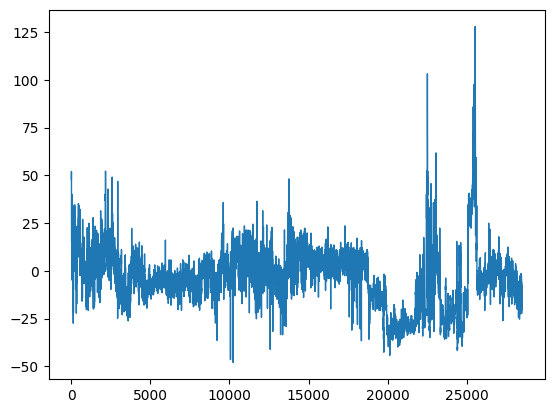

In [290]:
# reg = RandomForestRegressor(random_state=42, n_jobs=-1)
reg = LinearRegression()
mse, r2, res = train_regressor_with_missing_data(reg, X.columns, X, Y, X_missing_sandstone, Y_missing_sandstone, X_sandstone, Y_sandstone, log=True)

<Axes: xlabel='DTC', ylabel='Density'>

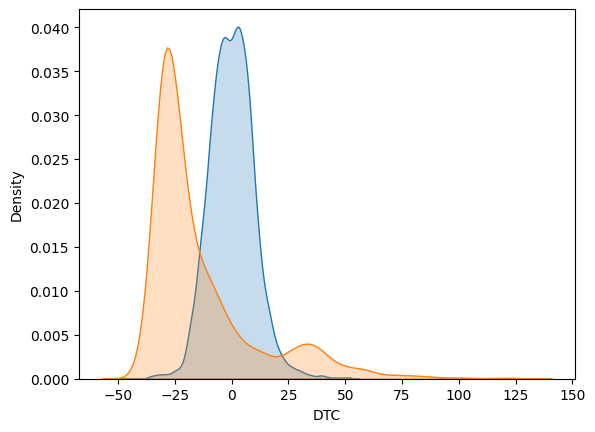

In [291]:
# sns.kdeplot(Y.DTC - res["all"], fill=True)
sns.kdeplot(res["gt_training"].DTC - res["training"], fill=True)
sns.kdeplot(res["gt_test"].DTC - res["test"], fill=True)

<Axes: xlabel='DTC', ylabel='Density'>

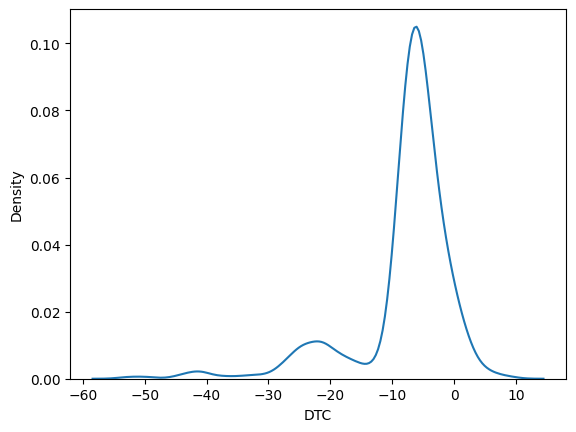

In [277]:
sns.kdeplot(res["gt_test"].DTC - res["test"])

### Missing last section
Perhaps it hasn't been drilled yet?

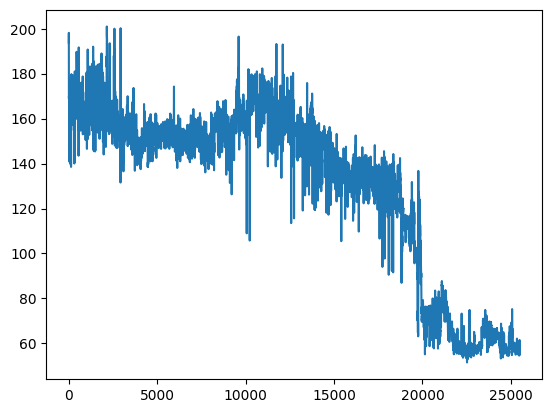

In [242]:
X_missing_last, X_last = remove_data(X, [25500], [4000])
Y_missing_last, Y_last = remove_data(Y, [25500], [4000])
plt.plot(Y_missing_last)

RMSE: 729.045
R2  : -2.356


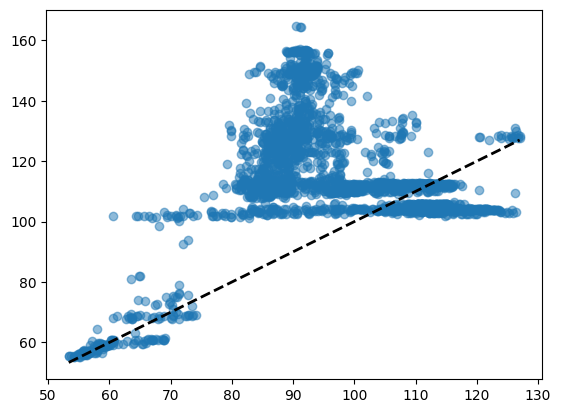

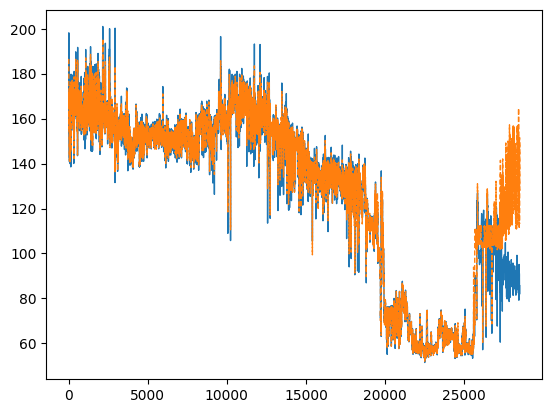

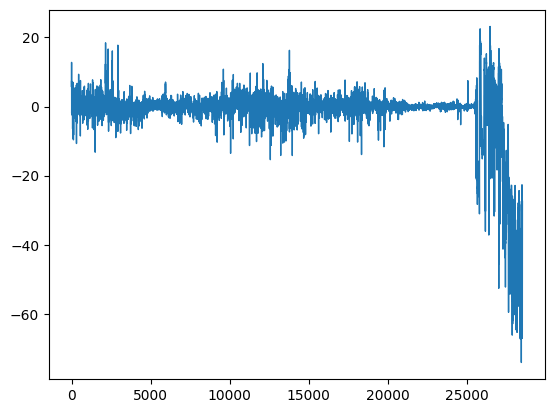

In [243]:
reg = RandomForestRegressor(random_state=42, n_jobs=-1)
# reg = LinearRegression()
mse, r2, res = train_regressor_with_missing_data(reg, X.columns, X, Y, X_missing_last, Y_missing_last, X_last, Y_last, log=True)

<Axes: xlabel='DTC', ylabel='Density'>

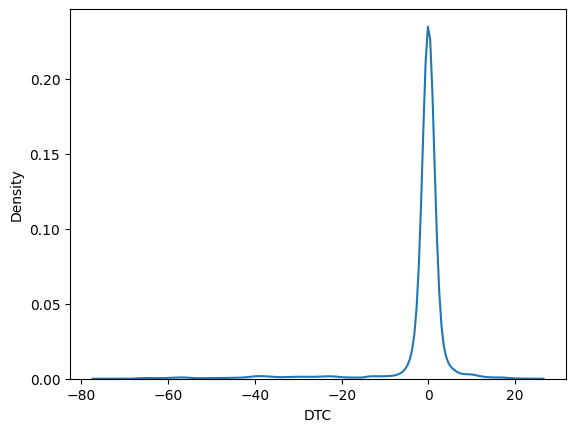

In [244]:
sns.kdeplot(Y.DTC - res["all"])

### 50% of data missing at regular intervals

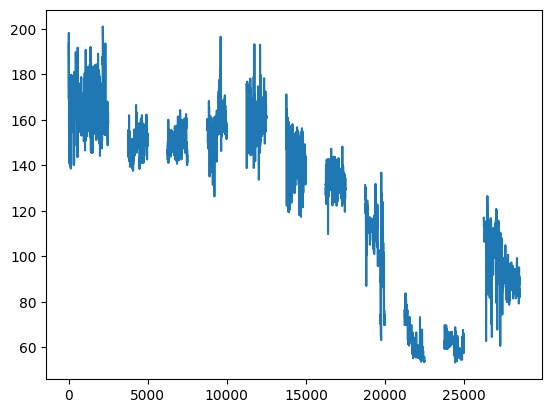

In [245]:
X_missing_50, X_50 = remove_data(pd.DataFrame(denoised.T, columns=X.columns), 
                                 [2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000], 
                                 [1250]*10)
Y_missing_50, Y_50 = remove_data(Y, 
                                 [2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000], 
                                 [1250]*10)
plt.plot(Y_missing_50)

RMSE: 272.630
R2  : 0.820


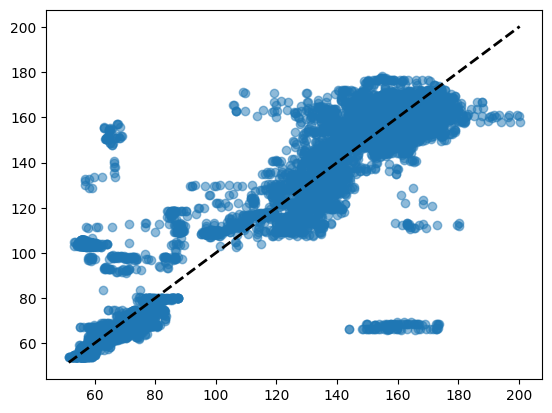

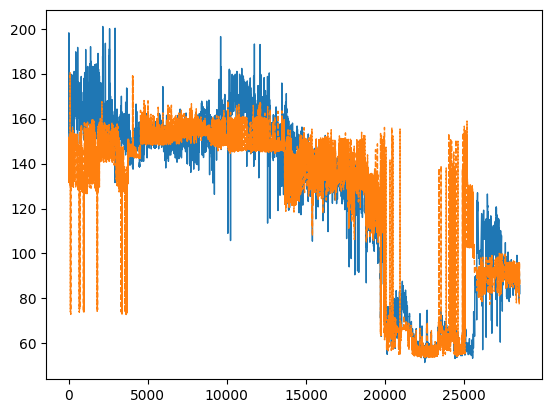

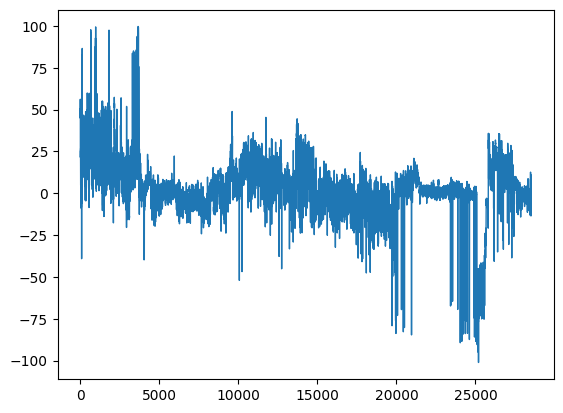

In [246]:
reg = RandomForestRegressor(random_state=42, n_jobs=-1)
# reg = LinearRegression()
mse, r2, res = train_regressor_with_missing_data(reg, X.columns, X, Y, X_missing_50, Y_missing_50, X_50, Y_50, log=True)

<Axes: xlabel='DTC', ylabel='Density'>

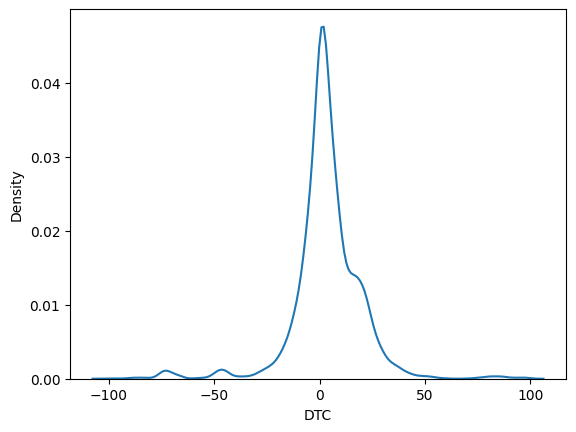

In [247]:
sns.kdeplot(Y.DTC - res["all"])

### 75% of data missing at regular intervals

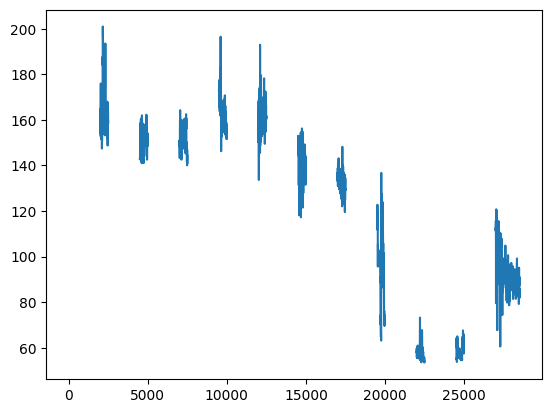

In [249]:
X_missing_75, X_75 = remove_data(X, 
                                 [1, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000], 
                                 [2000]*11)
Y_missing_75, Y_75 = remove_data(Y, 
                                 [1, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000], 
                                 [2000]*11)
plt.plot(Y_missing_75)

RMSE: 93.986
R2  : 0.933


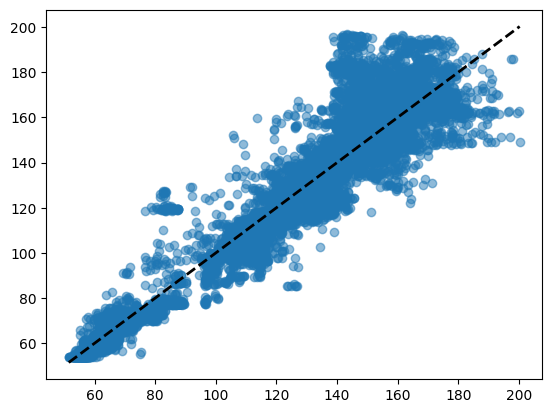

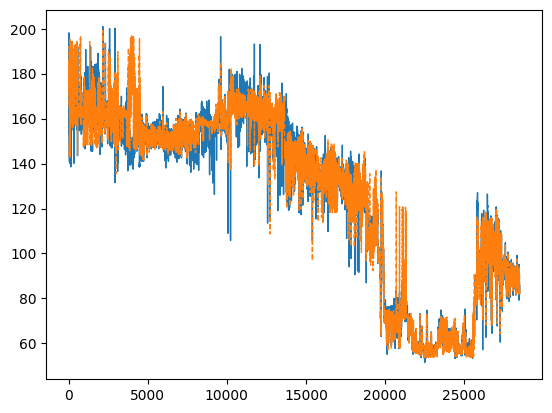

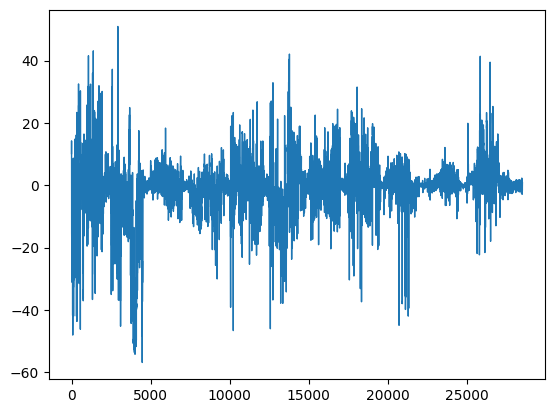

In [251]:
reg = RandomForestRegressor(random_state=42, n_jobs=-1)
# reg = LinearRegression()
mse, r2, res = train_regressor_with_missing_data(reg, X.columns, X, Y, X_missing_75, Y_missing_75, X_75, Y_75, log=True)

<Axes: xlabel='DTC', ylabel='Density'>

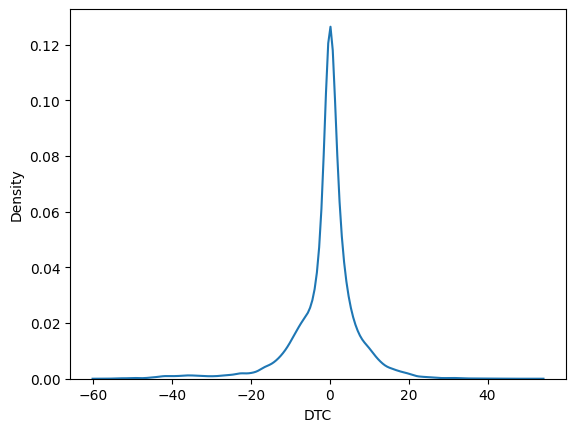

In [252]:
sns.kdeplot(Y.DTC - res["all"])

### Missing middle section
A long section is missing, perhaps it is not near a reservoir, so they do not care?

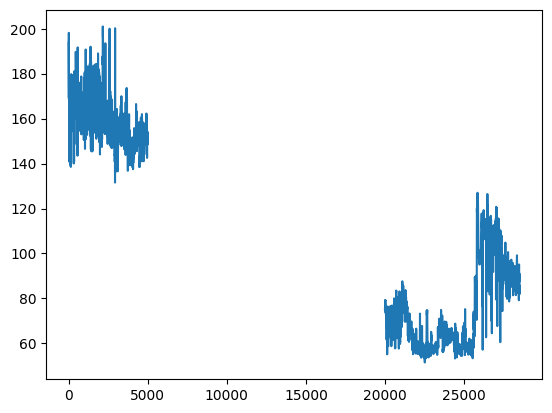

In [260]:
X_missing_middle, X_middle = remove_data(X, [5000], [15000])
Y_missing_middle, Y_middle = remove_data(Y, [5000], [15000])
plt.plot(Y_missing_middle)

RMSE: 265.580
R2  : 0.132


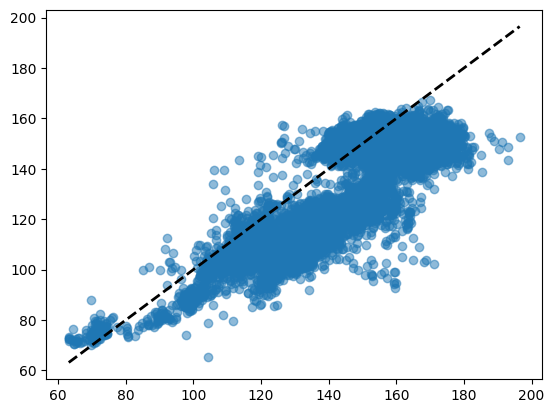

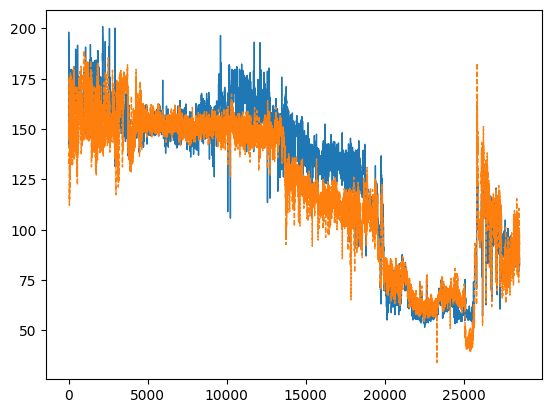

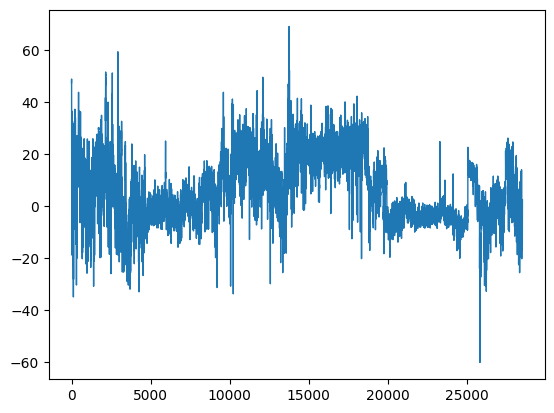

In [268]:
# reg = RandomForestRegressor(random_state=42, n_jobs=-1)
reg = LinearRegression()
mse, r2, res = train_regressor_with_missing_data(reg, X.columns, X, Y, X_missing_middle, Y_missing_middle, X_middle, Y_middle, log=True)

<Axes: xlabel='DTC', ylabel='Density'>

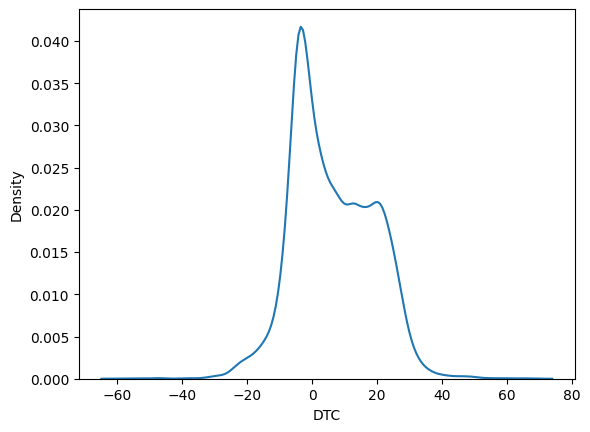

In [269]:
sns.kdeplot(Y.DTC - res["all"])

## End of notebook